# Measurement metrics result analysis

This notebook is used for the investigation of the retrieved metrics.
Images are stored to the `outputs/figures` folder.
The tables are stored in a word file in the `outputs/tables` named df_tables.
It is recommended to create the word file and add a content table before running the code.

In [1]:
# Imports
import json
import os, sys
import csv 
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import docx
import time
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import dataframe_image as dfi
from matplotlib.colors import ListedColormap
a4_dims = (11.7, 8.27)
palette = sns.color_palette('Paired', 10)
# seaborn_colormap = ListedColormap(sns.color_palette('Paired', 10))   
seaborn_colormap = ListedColormap(palette)   
# sns.set(style="whitegrid", font_scale=1.5)
sns.set_context("paper", rc={"figure.figsize": (12, 6)})
sns.set_theme(font_scale=1.5, style="whitegrid", palette=palette)



In [2]:
def json_to_dict(path):
    """
    Helper function
    :param path: Path to json file
    :return: dictionary with json content
    """
    with open(path) as json_file:
        data = json.load(json_file)
    return data

In [3]:
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

path_csv = os.path.join(parent_dir,"outputs", "data", "small_sample.csv")
raw_csv = open(path_csv, encoding="utf-8-sig")
reader = csv.reader(raw_csv, delimiter=";")
content_list = list(reader)
repo_sample_df = pd.DataFrame(content_list[1:],columns=content_list[0])
path_metrics = os.path.join(parent_dir,"outputs", "results", "csv_metrics.json")
path_repository = os.path.join(parent_dir,"outputs", "data", "csv_repository.json")
metrics_dict = json_to_dict(path=path_metrics)
repository_dict = json_to_dict(path=path_repository)
path_metrics_periods_path = os.path.join(parent_dir,"outputs", "results", "metric_date_ranges.json")
metrics_periods = json_to_dict(path=path_metrics_periods_path)
path_word = os.path.join(parent_dir,"analysis", "tables", "df_tables.docx")

In [4]:
df_metric_periods = pd.DataFrame()
columns = ["language", "metric", "objective", "min_date", "max_date"]
for lang, metrics in metrics_periods.items():
    for metric, data in metrics.items():
        for feature, periods in data.items():
            min_date = periods.get("min_date")
            max_date = periods.get("max_date")
            date_diff = periods.get("date_diff_days")
            new_row = {"language": lang,
            "metric": metric,
            "objective": feature,
            "min_date": min_date,
            "max_date": max_date,
            "date_diff_days": date_diff
            }
            tmp_df = pd.DataFrame(new_row, index=[len(df_metric_periods)])
            df_metric_periods = pd.concat([df_metric_periods, tmp_df])


# pd.json_normalize(path_metrics_periods).transpose()

In [5]:
def add_table_to_word(df):
    doc = docx.Document(path_word)
    name =[x for x in globals() if globals()[x] is df][0]
    doc.add_heading(name)
    df = df.round(3)
    table = doc.add_table(df.shape[0]+1, df.shape[1])
    table.allow_autofit = True
    table.autofit = True
    # add the header rows.
    for j in range(df.shape[-1]):
        table.cell(0,j).text = df.columns[j]

    # add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            table.cell(i+1,j).text = str(df.values[i,j])

    # save the doc
    doc.save(path_word)

In [6]:
add_table_to_word(df_metric_periods)
add_table_to_word(repo_sample_df)
time.sleep(3)

In [7]:
def get_metrics(metrics, metrics_dict=metrics_dict, repository_dict=repository_dict, png_filename="", study=""):
    result = {}
    if study:
        repo_study_df = repo_sample_df[repo_sample_df['study'].str.contains(study)]
    else:
        repo_study_df = repository_dict
    for metric, info in metrics.items():
        if isinstance(info, list):
            for info_elem in info:
                value_list = []
                repo_list = []
                metric_key = metric + "_" + info_elem
                for repo, item in repository_dict.items():
                    name = item.get("name")
                    if isinstance(metrics_dict, dict) and metric != "security_advisories":
                        try:
                            value = metrics_dict.get(metric).get(repo).get(info_elem)
                        except AttributeError as attr_err:
                            # print(metric)
                            # print(repo)
                            # print(f"AttributeError: {attr_err}")
                            pass        
                    else:
                        value = metrics_dict.get(metric)[0].get(repo).get(info_elem)
                        # print(metrics_dict.get(metric).get(repo))
                    if study and name in repo_study_df["repository"].values:
                        login = item.get("owner").get("login")
                        repo_list.append((name + "_" + login))
                        value_list.append(value)
                    elif not study:
                        login = item.get("owner").get("login")
                        repo_list.append((name + "_" + login))
                        value_list.append(value)
                result["repository"] = repo_list        
                result[metric_key] = value_list
        else:
            value_list = []
            repo_list = []
            if info:
                metric_key = info
            else:
                metric_key = metric
            
            for repo, item in repository_dict.items():
                name = item.get("name")
                if info:
                    value = metrics_dict.get(metric).get(repo).get(info)
                else:
                    value = metrics_dict.get(metric).get(repo)
                if study and name in repo_study_df["repository"].values:
                    login = item.get("owner").get("login")
                    repo_list.append((name + "_" + login))
                    value_list.append(value)
                elif not study:
                    login = item.get("owner").get("login")
                    repo_list.append((name + "_" + login))
                    value_list.append(value)
            result["repository"] = repo_list        
            result[metric_key] = value_list
        
    df = pd.DataFrame.from_dict(result)
    if png_filename:
        df.dfi.export(png_filename)
    return df


## Literature Sample

### Overview

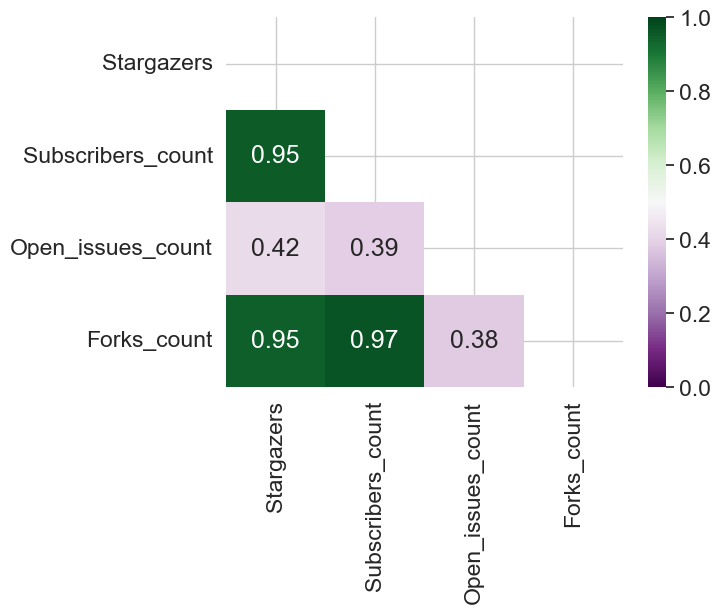

In [8]:
maturity = metrics_dict.get("maturity_level")
size_of_community = metrics_dict.get("size_of_community")
star_maturity_dict = {}
repo_list = []
star_list = []
sub_list = []
open_issues_list = []
forks_count_list = []
maturity_list = []
size_of_community_list = []
for repo, item in repository_dict.items():
    name = item.get("name")
    login = item.get("owner").get("login")
    repo_list.append((name + "_" + login))
    star_list.append(item.get("stargazers_count"))
    maturity_list.append(maturity.get(repo))
    size_of_community_list.append(size_of_community.get(repo))
    sub_list.append(item.get("subscribers_count"))
    open_issues_list.append(item.get("open_issues"))
    forks_count_list.append(item.get("forks_count"))
star_maturity_dict["Repository"] = repo_list
star_maturity_dict["Stargazers"] = star_list
star_maturity_dict["Subscribers_count"] = sub_list
star_maturity_dict["Open_issues_count"] = open_issues_list
star_maturity_dict["Forks_count"] = forks_count_list
df = pd.DataFrame.from_dict(star_maturity_dict)
df_corr_small_01 = df[["Stargazers", "Subscribers_count", "Open_issues_count", "Forks_count"]].corr(method="spearman")
matrix = np.triu(df_corr_small_01)
corr_fig = sns.heatmap(df_corr_small_01, cmap='PRGn', annot=True, mask=matrix, vmin=0, vmax=1)

plt.savefig("figures/overview_corr_fig.png", bbox_inches='tight')
# df_corr_small_01.dfi.export(png_filename)
# df = pd.melt(df, id_vars="Repository", var_name="Objective", value_name="Value")


In [9]:
temp_df = repo_sample_df['study'].str.rsplit(',', expand=True).add_prefix('Study_').join(repo_sample_df)
temp_df = temp_df.drop("study", axis=1)
temp_df["owner_repository"] = temp_df["owner"] + "/" + temp_df["repository"]
temp_df = temp_df.drop(["owner", "repository"], axis=1)
temp_df = pd.melt(temp_df, id_vars=["owner_repository"], value_name="Study")
temp_df = temp_df.drop("variable", axis=1)
temp_df = temp_df[temp_df['Study'].notna()].reset_index(drop=True)
temp_df['Study'] = temp_df['Study'].str.strip()
temp_df['owner_repository'] = temp_df['owner_repository'].str.strip()
di = {"aman": "Aman et al. 2017 [6]",
    "b": "Bhandari et al. 2021 [11]",
    "cha": "Chan et al. 2022 [12]",
    "cho": "Chong et al. 2019 [22]",
    "f": "Foucault et al. 2015 [29]",
    "t": "Tan et al. 2022 [16]",
    "w": "Wang et al. 2022 [7]",
    "z": "Zhang et al. 2021 [18]"}
temp_df = temp_df.replace({"Study": di})
studies_count_df = temp_df.groupby("Study").count().reset_index()
studies_count_df = studies_count_df.groupby(['Study']).sum().reset_index()
studies_count_df.columns = ["Study", "Included repositories"]
studies_count_df = studies_count_df.sort_values(by=['Included repositories'], ascending=False).reset_index(drop=True)
add_table_to_word(studies_count_df)
time.sleep(3)
# png_filename = "df_small_sample_study_counts.png"
# count_df.dfi.export(png_filename)

In [10]:
studies_duplicates_df = temp_df[temp_df.duplicated("owner_repository", keep=False)].sort_values(by=["owner_repository"])
studies_duplicates_df = studies_duplicates_df.groupby(['owner_repository'])['Study'].apply(', '.join).reset_index()
studies_duplicates_df.columns = ["Included repositories", "Studies"]
add_table_to_word(studies_duplicates_df)
time.sleep(3)
# png_filename = "df_small_sample_study_duplicates.png"
# duplicates_df.dfi.export(png_filename)

In [11]:
metrics = {
    "maturity_level": None,
    "osi_approved_license": None,
    "criticality_score":None,
    "technical_fork": ["total_forks", "average_forks_created_per_week"],
    "pull_requests": ["total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"],
    "project_velocity": ["total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"],
    "github_community_health_percentage": ["community_health_score","custom_health_score", "true_count", "false_count", "description", "documentation", "code_of_conduct",
                                          "contributing", "issue_template", "pull_request_template", "license", "readme"],
    "issues": ["total_issues", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"],
    "support_rate": None,
    "code_dependency": ["total_upstream", "total_downstream"],
    "security_advisories": ["advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"],
    "contributions_distributions": ["bus_factor_score","RoF_tail", "RoF_dominant", "RoF_diff_percent", "avg_num_contributors_per_file",
                                    "NoC_tail", "NoC_dominant", "NoC_diff_percent"],
    "number_of_support_contributors": None,
    "elephant_factor": None,
    "size_of_community": None,
    "churn": None,
    "branch_lifecycle": ["branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio", "branch_state_counter"]
}
literature_sample = get_metrics(metrics=metrics)

### OSI approved license

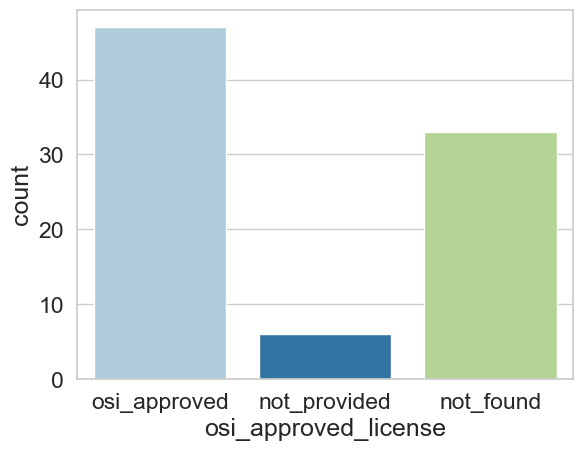

In [12]:
literature_osi = literature_sample [["repository", "osi_approved_license"]]
sns.countplot(x ='osi_approved_license', data = literature_osi, palette=palette)
plt.savefig("figures/literature_osi.png", bbox_inches='tight')

### Churn

In [13]:
literature_churn = literature_sample [["repository", "churn"]]
literature_churn_head = literature_churn.head(20)
png_filename = "small_sample_churn_metrics_top20.png"
add_table_to_word(literature_churn_head)
time.sleep(3)
literature_churn_summary = literature_churn['churn'].describe().to_frame().transpose()

### Branches

In [14]:
literature_branches = literature_sample [["repository", "branch_lifecycle_branch_state_counter",
    "branch_lifecycle_branch_creation_frequency_days", "branch_lifecycle_branch_avg_age_days",
    "branch_lifecycle_stale_ratio", "branch_lifecycle_active_ratio", "branch_lifecycle_unresolved_ratio", "branch_lifecycle_resolved_ratio"]]
columns_new = ["repository", "branch_state_counter", "branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]
literature_branches = literature_branches.set_axis(columns_new, axis='columns')
literature_branches_head = literature_branches.head(20)
add_table_to_word(literature_branches_head)
time.sleep(3)

literature_branches_summary = literature_branches[["branch_state_counter", "branch_creation_frequency_days",
    "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]].describe().transpose()

In [15]:
def label_branch (row):
   if row['variable'] == 'stale_ratio' :
      return 'Activity State'
   if row['variable'] == 'active_ratio':
      return 'Activity State'
   if row['variable'] == 'unresolved_ratio':
      return 'Resolved State'
   if row['variable']  == 'resolved_ratio':
      return 'Resolved State'
   return 'Other'


C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\3896024306.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.histplot(literature_branches_bar_01, x='repository', hue='variable', weights='value', multiple='stack', palette=palette)


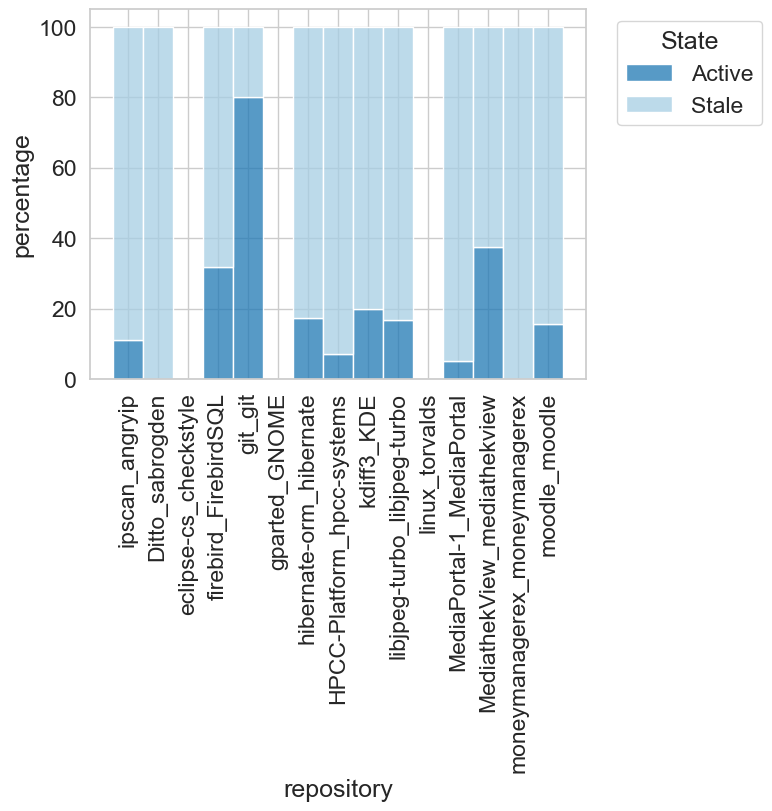

In [16]:
literature_branches_bar_01 = pd.melt(literature_branches[:15], id_vars=["repository"],
    value_vars=["stale_ratio", "active_ratio"])
literature_branches_bar_01["State"] = literature_branches_bar_01.apply(lambda row: label_branch(row), axis=1)
literature_branches_bar_01['value'] = literature_branches_bar_01['value'].fillna(0)

ax = sns.histplot(literature_branches_bar_01, x='repository', hue='variable', weights='value', multiple='stack', palette=palette)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="State", labels=['Active', 'Stale'])
ax.set(ylabel='percentage')
plt.xticks(rotation=90)
plt.savefig("figures/df_literature_health_bar_01.png", bbox_inches='tight')

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\1255556979.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.histplot(literature_branches_bar_02, x='repository', hue='variable', weights='value', multiple='stack', palette=palette)


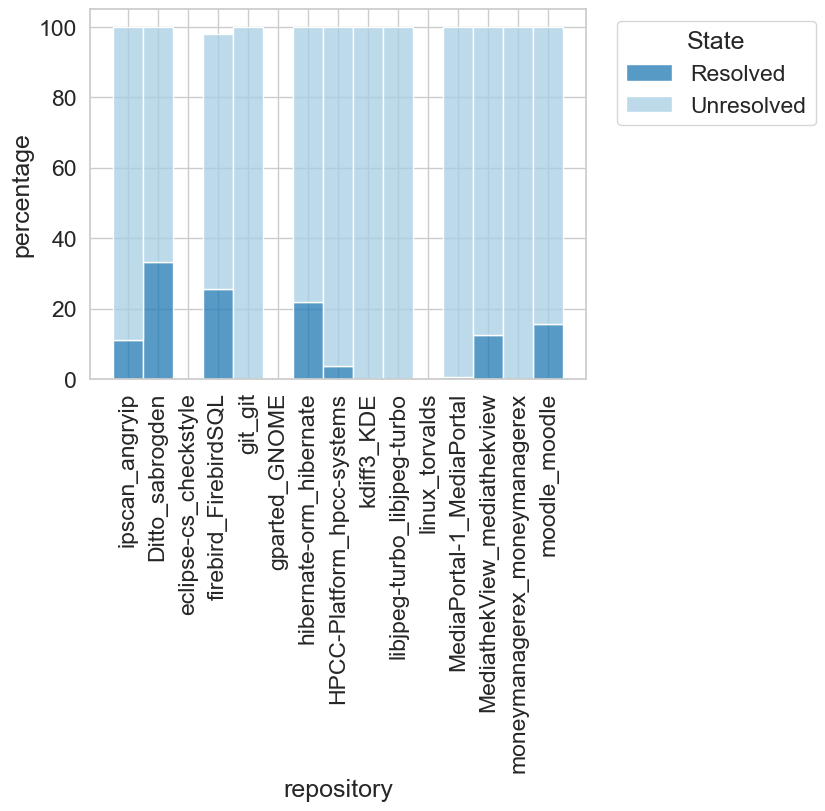

In [17]:
literature_branches_bar_02 = pd.melt(literature_branches[:15], id_vars=["repository"],
    value_vars=["unresolved_ratio", "resolved_ratio"])
literature_branches_bar_02["State"] = literature_branches_bar_02.apply(lambda row: label_branch(row), axis=1)
literature_branches_bar_02['value'] = literature_branches_bar_02['value'].fillna(0)
# fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(literature_branches_bar_02, x='repository', hue='variable', weights='value', multiple='stack', palette=palette)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="State", labels=['Resolved', 'Unresolved'])
ax.set(ylabel='percentage')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.savefig("figures/df_literature_health_bar_02.png", bbox_inches='tight')

### Contributions Distributions

In [18]:
literature_contributions = literature_sample [["repository", "contributions_distributions_bus_factor_score", "elephant_factor",
   "contributions_distributions_RoF_tail", "contributions_distributions_RoF_dominant",
    "contributions_distributions_RoF_diff_percent", "contributions_distributions_avg_num_contributors_per_file",
    "contributions_distributions_NoC_tail", "contributions_distributions_NoC_dominant",
    "contributions_distributions_NoC_diff_percent"]]
columns_new = ["repository", "bus_factor_score", "elephant_factor","RoF_tail", "RoF_dominant", "RoF_diff_percent", "avg_num_contributors_per_file",
                                    "NoC_tail", "NoC_dominant", "NoC_diff_percent"]
literature_contributions = literature_contributions.set_axis(columns_new, axis='columns')
png_filename = "small_sample_contrib_metrics.png"

literature_contributions_summary = literature_contributions[["bus_factor_score", "elephant_factor","RoF_tail", "RoF_dominant", "RoF_diff_percent", "avg_num_contributors_per_file",
                                    "NoC_tail", "NoC_dominant", "NoC_diff_percent"]].describe()
literature_contributions_summary = literature_contributions_summary.transpose()[["count", "mean", "min", "max"]]
literature_contributions_summary['Metric'] = literature_contributions_summary.index
add_table_to_word(literature_contributions_summary)
time.sleep(3)

In [115]:
grafana_contrib = literature_contributions.loc[literature_contributions['repository'] == "grafana_grafana"][["repository", "bus_factor_score",
"elephant_factor",  "avg_num_contributors_per_file", "RoF_diff_percent", "RoF_dominant", "NoC_diff_percent", "NoC_dominant"]].reset_index(drop=True)
add_table_to_word(grafana_contrib)
time.sleep(3)

In [116]:
grafana_contrib

,repository,bus_factor_score,elephant_factor,avg_num_contributors_per_file,RoF_diff_percent,RoF_dominant,NoC_diff_percent,NoC_dominant
0,grafana_grafana,29.000,1,1.746,11.351,31.351,19.894,39.894


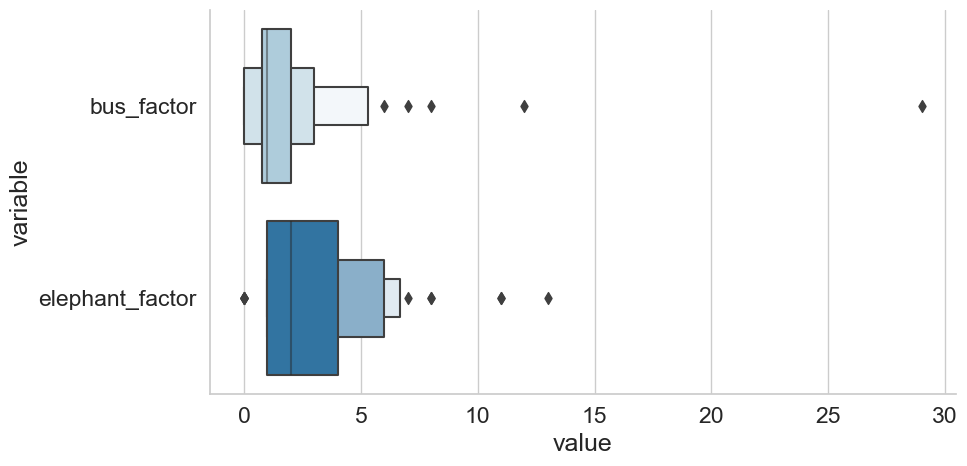

In [21]:
literature_bus_elephant_factors = literature_sample[["repository","contributions_distributions_bus_factor_score", "elephant_factor"]]

columns_new = ["repository","bus_factor", "elephant_factor"]
literature_bus_elephant_factors = literature_bus_elephant_factors.set_axis(columns_new, axis='columns')

literature_bus_elephant_factors = pd.melt(literature_bus_elephant_factors, id_vars=["repository"],
    value_vars=["bus_factor","elephant_factor"])

sns.catplot(data=literature_bus_elephant_factors, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/literature_bus_elephant_factors.png", bbox_inches='tight')

### Security Advisories

In [22]:
literature_advisories = literature_sample [["repository", "security_advisories_advisories_available", "security_advisories_patch_ratio",
    "security_advisories_closed_advisories", "security_advisories_average_cvss_score", "security_advisories_ratio_severity_high_crit"]]
columns_new = ["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]
literature_advisories = literature_advisories.set_axis(columns_new, axis='columns')

literature_advisories = literature_advisories.sort_values("advisories_available", ascending=False).reset_index(drop=True)
literature_advisories_head = literature_advisories.head(15)
add_table_to_word(literature_advisories_head)
time.sleep(3)
literature_advisories_summary = literature_advisories[["advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]].describe()
literature_advisories_summary = literature_advisories_summary.transpose()

### Code Dependency

In [23]:
literature_dependencies = literature_sample [["repository", "code_dependency_total_upstream", "code_dependency_total_downstream"]]
columns_new = ["repository", "total_upstream", "total_downstream"]
literature_dependencies = literature_dependencies.set_axis(columns_new, axis='columns')
png_filename = "small_sample_dependencies_metrics.png"
literature_dependencies.dfi.export(png_filename)
literature_dependencies_head = literature_dependencies.head(10)

add_table_to_word(literature_dependencies_head)
time.sleep(3)
literature_dependencies_summary = literature_dependencies[["total_upstream", "total_downstream"]].describe().transpose()

### Issues

In [24]:
literature_issues = literature_sample[["repository", "issues_open_issues", "issues_closed_issues", "issues_new_issues", "issues_new_ratio",
"issues_average_issues_created_per_week", "issues_average_issue_comments", "issues_average_issue_resolving_days",
              "issues_average_first_response_time_days", "issues_ratio_open_total", "issues_ratio_closed_total"]]
columns_new = ["repository", "open_issues", "closed_issues", "new_issues", "new_ratio",
"average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]
literature_issues = literature_issues.set_axis(columns_new, axis='columns')
literature_issues_head = literature_issues.head(5).sort_values("average_issues_created_per_week", ascending=False)
add_table_to_word(literature_issues_head)
time.sleep(3)
literature_issues_summary = literature_issues[["open_issues", "closed_issues", "new_issues", "new_ratio",
    "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]].describe()
literature_issues_summary = literature_issues_summary.transpose()
add_table_to_word(literature_issues_summary)
time.sleep(3)

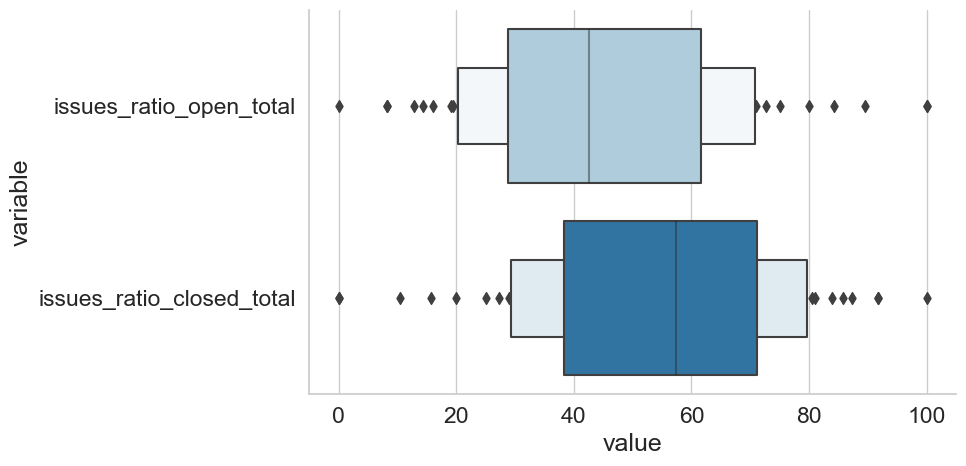

In [25]:
literature_issues_box = literature_sample[["repository",
    "issues_ratio_open_total", "issues_ratio_closed_total"]]

literature_issues_box = pd.melt(literature_issues_box, id_vars=['repository'], value_vars=["issues_ratio_open_total", "issues_ratio_closed_total"])

sns.catplot(data=literature_issues_box, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/literature_issues_box.png", bbox_inches='tight')

### Community Health Score

In [26]:
literature_health = literature_sample [["repository", "github_community_health_percentage_community_health_score","github_community_health_percentage_custom_health_score",
    "github_community_health_percentage_true_count", "github_community_health_percentage_false_count", "github_community_health_percentage_description",
    "github_community_health_percentage_documentation", "github_community_health_percentage_code_of_conduct",
    "github_community_health_percentage_contributing", "github_community_health_percentage_issue_template",
    "github_community_health_percentage_pull_request_template", "github_community_health_percentage_license", "github_community_health_percentage_readme"]]
columns_new = ["repository", "community_health_score","custom_health_score",
    "true_count", "false_count", "description", "documentation", "code_of_conduct",
    "contributing", "issue_template", "pull_request_template", "license", "readme"]
literature_health = literature_health.set_axis(columns_new, axis='columns')
literature_health_head = literature_health.head(10)
add_table_to_word(literature_health_head)
time.sleep(3)
literature_health_summary = literature_health[["repository", "community_health_score","custom_health_score"]].describe(include="all").transpose()

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\1409874569.py:7: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(df_literature_health_bar, x='variable', hue='value', weights='repository', multiple='stack', palette=palette)


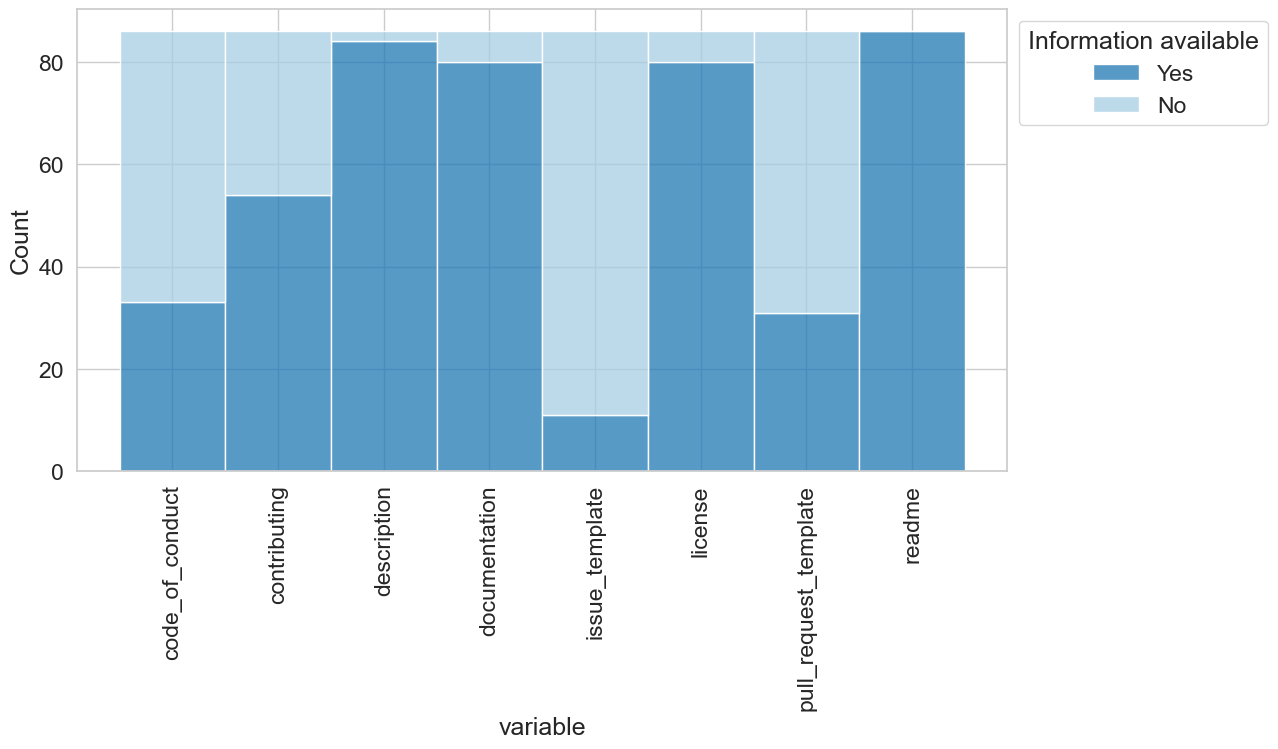

In [27]:
df_literature_health_bar = pd.melt(literature_health, id_vars=["repository"],
    value_vars=["description", "documentation", "code_of_conduct",
    "contributing", "issue_template", "pull_request_template", "license", "readme"])
df_literature_health_bar = df_literature_health_bar.groupby(["variable", "value"]).count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(df_literature_health_bar, x='variable', hue='value', weights='repository', multiple='stack', palette=palette)
plt.legend(title="Information available", labels=['Yes', 'No'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.savefig("figures/df_literature_health_bar.png", bbox_inches='tight')

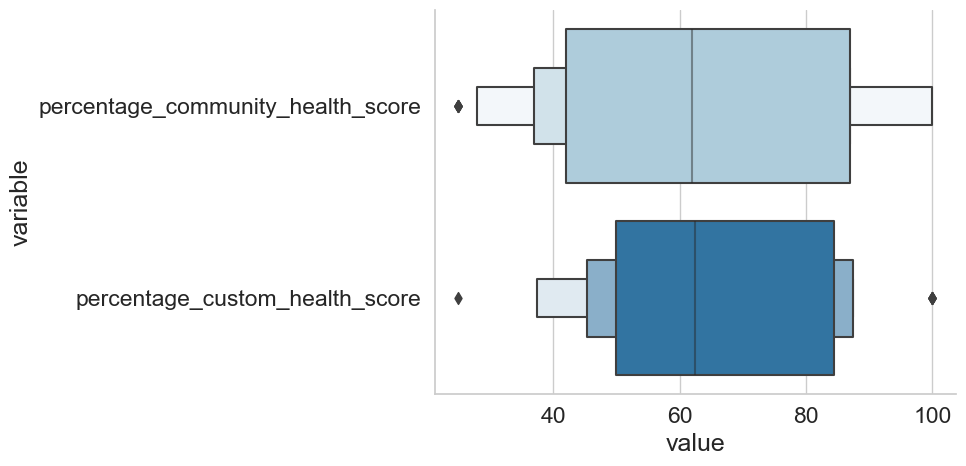

In [28]:
literature_health_box = literature_sample[["repository","github_community_health_percentage_community_health_score", "github_community_health_percentage_custom_health_score"]]
columns_new = ["repository","percentage_community_health_score", "percentage_custom_health_score"]
literature_health_box = literature_health_box.set_axis(columns_new, axis='columns')

df_literature_health = pd.melt(literature_health_box, id_vars=["repository"],
    value_vars=["percentage_community_health_score","percentage_custom_health_score"])

sns.catplot(data=df_literature_health, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/df_literature_health.png", bbox_inches='tight')

### Project Velocity

In [29]:
literature_project_velocity = literature_sample[["repository", "project_velocity_total_issues", "project_velocity_closed_issues", "project_velocity_open_issues",
    "project_velocity_pull_count", "project_velocity_no_pull_count", "project_velocity_ratio_pull_issue",
    "project_velocity_avg_issue_resolving_days", "project_velocity_ratio_open_total", "project_velocity_ratio_closed_total"]]
columns_new = ["repository", "total_issues", "closed_issues", "open_issues",
    "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]
literature_project_velocity = literature_project_velocity.set_axis(columns_new, axis='columns')

png_filename = "small_sample_project_velocity_metrics.png"
literature_project_velocity.dfi.export(png_filename)
literature_project_velocity_head = literature_project_velocity.head(11)
add_table_to_word(literature_project_velocity_head)
time.sleep(3)
literature_project_velocity_summary = literature_project_velocity[["total_issues", "closed_issues", "open_issues",
    "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]].describe()
literature_project_velocity_summary = literature_project_velocity_summary.transpose()[["count", "mean", "std", "min", "max"]]
literature_project_velocity_summary['Metric'] = literature_project_velocity_summary.index
add_table_to_word(literature_project_velocity_summary)
time.sleep(3)

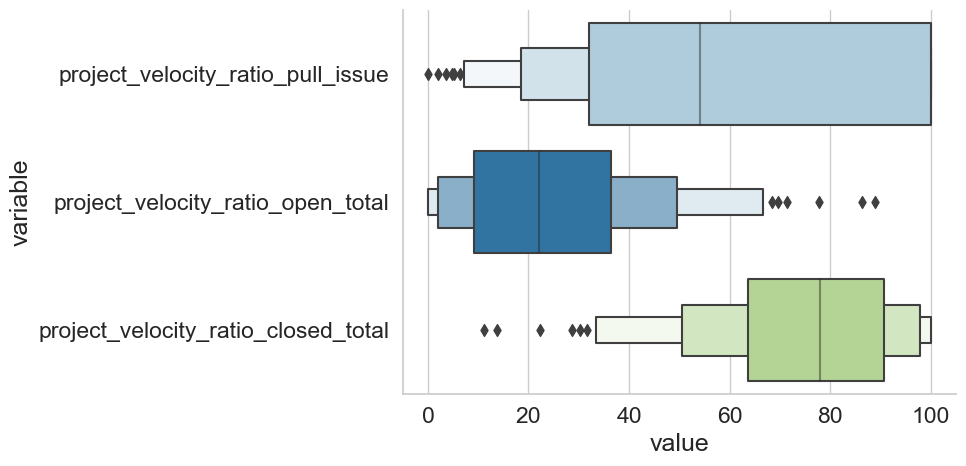

In [30]:
literature_project_velocity_box_ = literature_sample[["repository", "project_velocity_ratio_pull_issue",
    "project_velocity_ratio_open_total", "project_velocity_ratio_closed_total"]]

literature_project_velocity_box_ = pd.melt(literature_project_velocity_box_, id_vars=['repository'], value_vars=["project_velocity_ratio_pull_issue",
    "project_velocity_ratio_open_total", "project_velocity_ratio_closed_total"])

sns.catplot(data=literature_project_velocity_box_, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/literature_project_velocity_box_.png")

### Pull Requests

In [31]:
literature_pull_requests = literature_sample [["repository", "pull_requests_total_pulls", "pull_requests_avg_pull_closing_days",
    "pull_requests_ratio_open_total", "pull_requests_ratio_closed_total", "pull_requests_ratio_merged_total"]]

columns_new = ["repository", "total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"]
literature_pull_requests = literature_pull_requests.set_axis(columns_new, axis='columns')

literature_pull_requests_head = literature_pull_requests.head(10)
add_table_to_word(literature_pull_requests_head)
time.sleep(3)
literature_pull_requests_summary = literature_pull_requests[["total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"]].describe()
literature_pull_requests_summary = literature_pull_requests_summary.transpose()

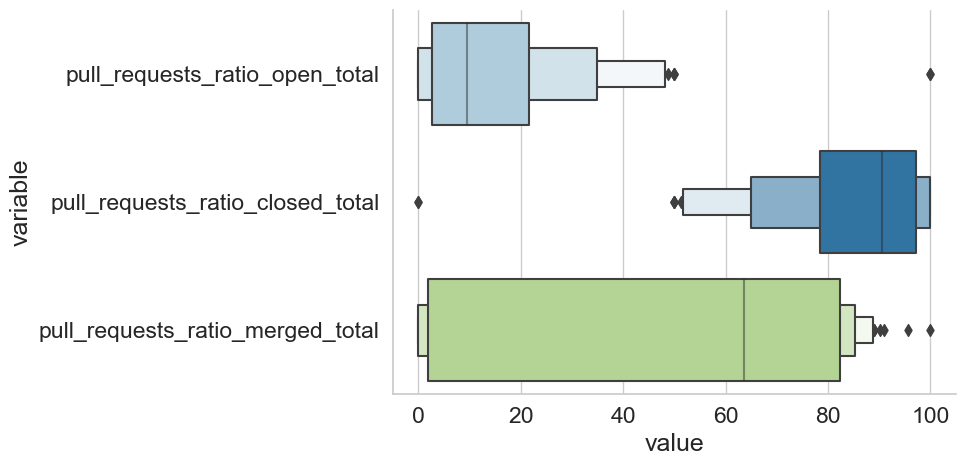

In [32]:
literature_pulls_box = literature_sample[["repository", "pull_requests_ratio_open_total", "pull_requests_ratio_closed_total", "pull_requests_ratio_merged_total"]]
literature_pulls_box = pd.melt(literature_pulls_box, id_vars=['repository'], value_vars=["pull_requests_ratio_open_total", "pull_requests_ratio_closed_total", "pull_requests_ratio_merged_total"])

sns.catplot(data=literature_pulls_box, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/literature_pulls_box.png", bbox_inches='tight')

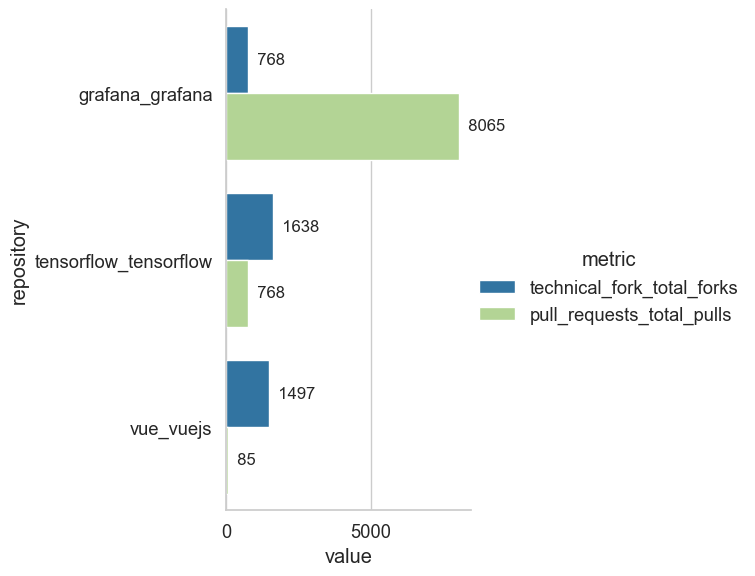

In [33]:
literature_pulls_forks_rel_bar = literature_sample[["repository","technical_fork_total_forks", "pull_requests_total_pulls"]]

literature_pulls_forks_rel_bar_cut = literature_pulls_forks_rel_bar.iloc[57:60]
literature_pulls_forks_rel_bar_cut = pd.melt(literature_pulls_forks_rel_bar_cut, id_vars=["repository"], value_name="value")
literature_pulls_forks_rel_bar_cut.columns = ["repository", "metric", "value"]
sns.set_theme(font_scale=1.2, style="whitegrid")
g = sns.catplot(
    data=literature_pulls_forks_rel_bar_cut, kind="bar",
    x="value", y="repository", hue="metric", 
    errorbar="sd", palette=palette[1:], height=6
)

ax = g.facet_axis(0, 0)
for container in ax.containers:
    ax.bar_label(container,size=12,fmt='  %.0f')
plt.savefig("figures/literature_pulls_forks_rel_bar.png")
sns.set_theme(font_scale=1.5, style="whitegrid")

### Technical Forks

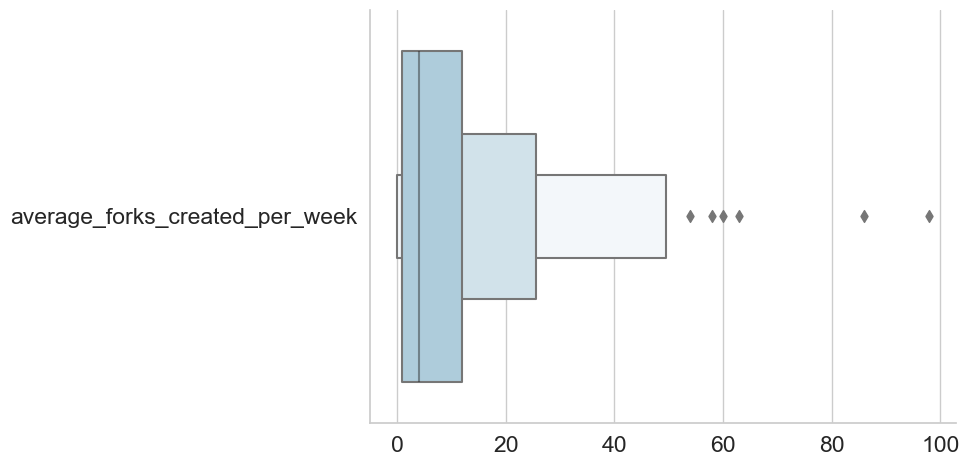

In [34]:
literature_forks = literature_sample[["repository","technical_fork_total_forks", "technical_fork_average_forks_created_per_week"]]

columns_new = ["repository","total_forks", "average_forks_created_per_week"]
literature_forks = literature_forks.set_axis(columns_new, axis='columns')
literature_forks_summary = literature_forks[["total_forks", "average_forks_created_per_week"]].describe().transpose()
literature_forks_box = literature_forks[["average_forks_created_per_week"]]
sns.catplot(data=literature_forks_box, kind="boxen", palette = palette, height=5, aspect=2, orient="h")
plt.savefig("figures/literature_forks_box.png", bbox_inches='tight')

### Scores

In [35]:
literature_scores = literature_sample [["repository","maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]]

literature_scores_summary = literature_scores[["maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]].describe()
literature_scores_summary = literature_scores_summary.transpose()

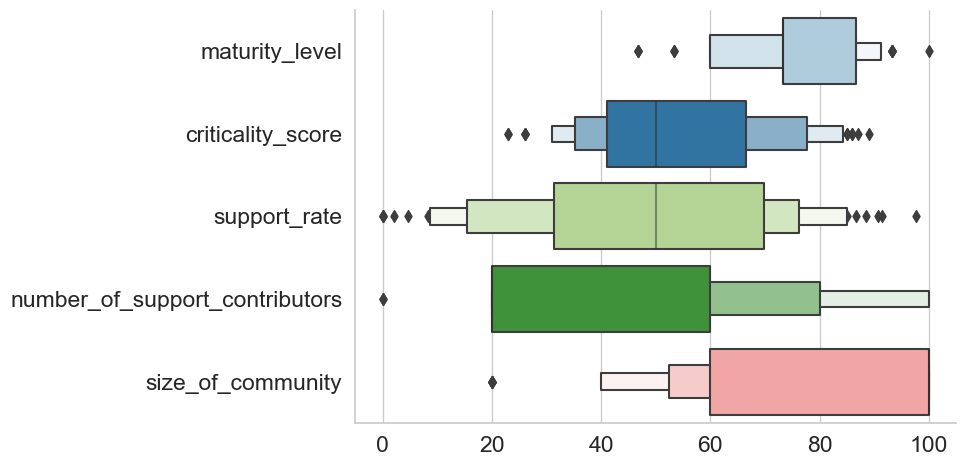

In [36]:
literature_scores_box = literature_sample[["maturity_level", "criticality_score", "support_rate", "number_of_support_contributors",
    "size_of_community"]]
sns.catplot(data=literature_scores_box, kind="boxen", palette = palette, height=5, aspect=2, orient="h")
plt.savefig("figures/literature_scores_box.png", bbox_inches='tight')

### Statistic Summary Complete

In [37]:
literature_churn_summary = pd.concat({'Churn': literature_churn_summary}, names=['Objective'])
literature_branches_summary = pd.concat({'Branch_Lifecycle': literature_branches_summary}, names=['Objective'])
literature_contributions_summary = pd.concat({'Contributions_Distributions': literature_contributions_summary}, names=['Objective'])
literature_advisories_summary = pd.concat({'Security_Advisories': literature_advisories_summary}, names=['Objective'])
literature_dependencies_summary = pd.concat({'Dependency': literature_dependencies_summary}, names=['Objective'])
literature_issues_summary = pd.concat({'Issues': literature_issues_summary}, names=['Objective'])
literature_health_summary = pd.concat({'Commmunity_Health': literature_health_summary}, names=['Objective'])
literature_project_velocity_summary = pd.concat({'Project_Velocity': literature_project_velocity_summary}, names=['Objective'])
literature_pull_requests_summary = pd.concat({'Pull_Requests': literature_pull_requests_summary}, names=['Objective'])
literature_forks_summary = pd.concat({'Technical_Forks': literature_forks_summary}, names=['Objective'])
literature_scores_summary = pd.concat({'Scores': literature_scores_summary}, names=['Objective'])

literature_summary = pd.concat([
literature_scores_summary,
literature_pull_requests_summary,
literature_project_velocity_summary,
literature_health_summary,
literature_issues_summary,
literature_dependencies_summary,
literature_advisories_summary,
literature_contributions_summary,
literature_churn_summary,
literature_branches_summary,
literature_forks_summary
])[["count", "mean", "std", "min", "max"]]

add_table_to_word(literature_summary)
time.sleep(3)

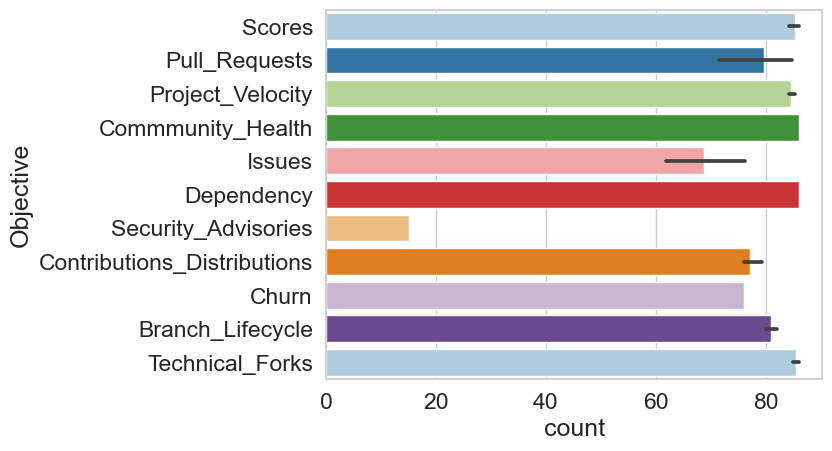

In [38]:
literature_summary_count = literature_summary[["count"]]
literature_summary_count = literature_summary_count.reset_index()

# literature_summary_count["Objective"] = literature_summary_count["Objective"] + " - " + literature_summary_count["level_1"]
literature_summary_count = literature_summary_count.drop("level_1", axis=1)
# plt.figure(figsize=(10,10))
# tmp_palette = sns.color_palette("BuPu", start=.5, rot=-.5)
sns.barplot(data=literature_summary_count, x= "count", y="Objective", orient = 'h', palette=palette)
plt.savefig("figures/literature_summary_count_02.png", bbox_inches='tight')

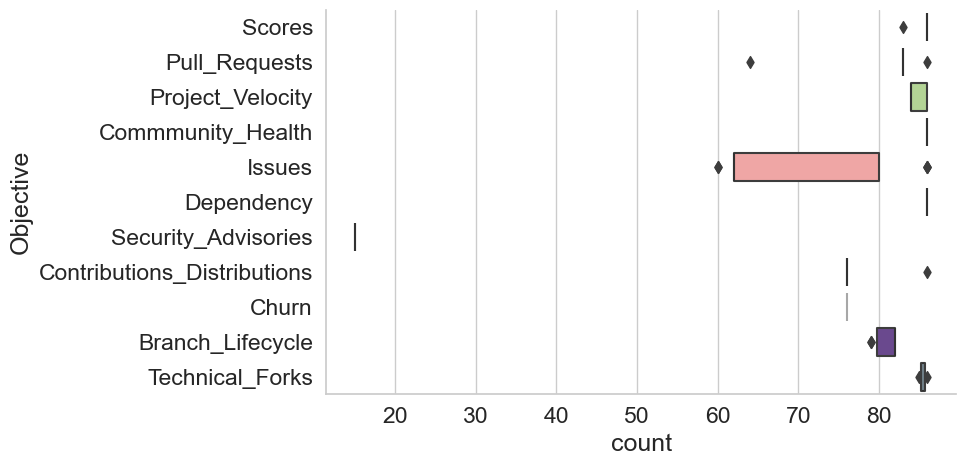

In [39]:
sns.catplot(data=literature_summary_count, kind="boxen", palette = palette, height=5, aspect=2, x= "count", y="Objective", orient = 'h')
plt.savefig("figures/literature_summary_count.png", bbox_inches='tight')

### Further visualizations

### Zhang et al.

In [40]:
repo_sample_zhang_df = repo_sample_df[repo_sample_df['study'].str.contains("z")]

In [41]:
zhang_metrics = {
    "size_of_community": None,
    "maturity_level": None,
    "osi_approved_license": None,
    "criticality_score":None,
    "support_rate":None,
    "number_of_support_contributors": None,
    "github_community_health_percentage": ["community_health_score","custom_health_score"]
}
zhang_df = get_metrics(metrics=zhang_metrics, study="z")


In [42]:
zhang_health = zhang_df[["repository", "osi_approved_license", "github_community_health_percentage_community_health_score", "github_community_health_percentage_custom_health_score"]]
columns_new = ["repository", "osi_approved_license", "community_health_score", "custom_health_score"]
zhang_health = zhang_health.set_axis(columns_new, axis='columns')

add_table_to_word(zhang_health)
time.sleep(3)

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\1593145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.fillna(0, inplace=True)


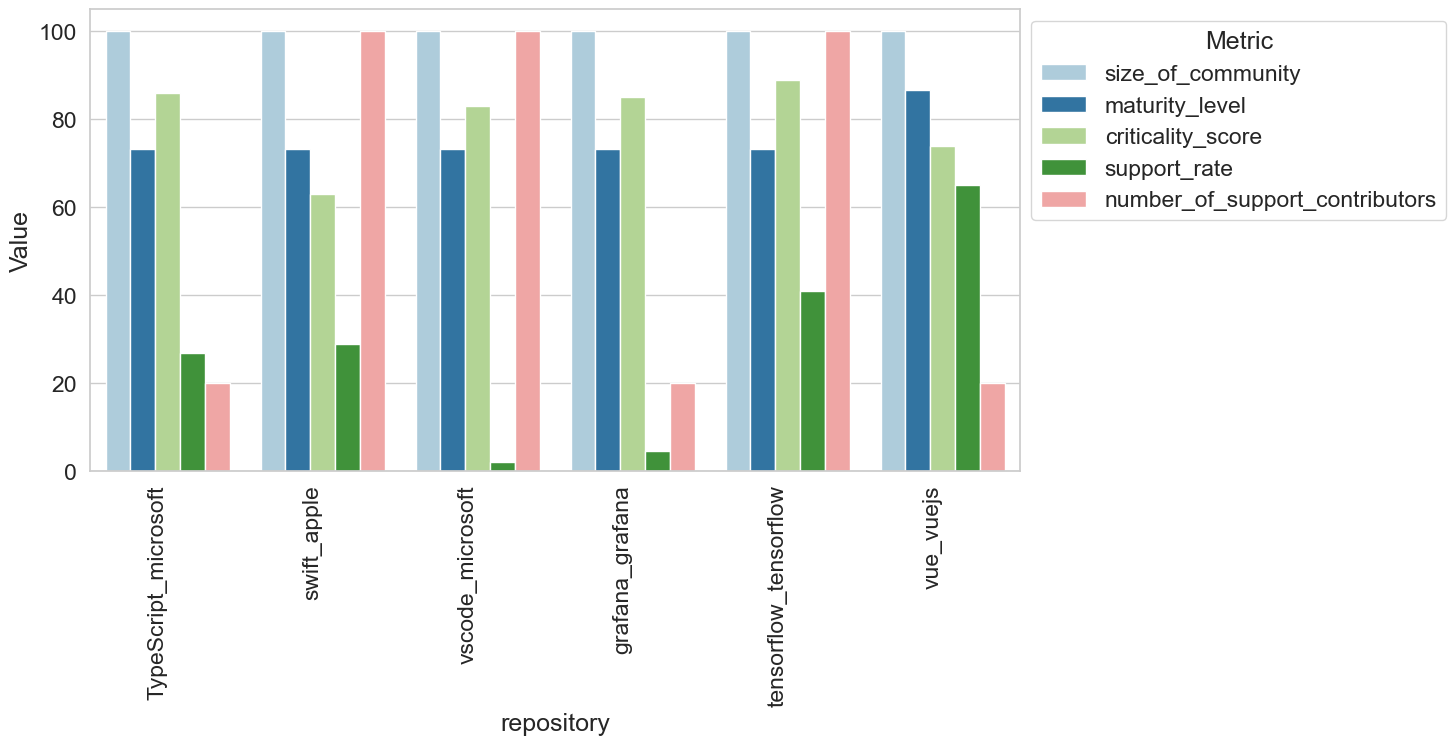

In [43]:
tmp_df = zhang_df[["repository", "size_of_community", "maturity_level", "criticality_score", "support_rate", "number_of_support_contributors"]]
tmp_df.fillna(0, inplace=True)
tmp_df = tmp_df.melt(id_vars=["repository"], 
        var_name="Metric", 
        value_name="Value")
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=tmp_df, x="repository", y="Value", hue="Metric", palette=palette)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.savefig("figures/zhang_scores.png", bbox_inches='tight')

### Wang et al.

In [44]:
repo_sample_wang_df = repo_sample_df[repo_sample_df['study'].str.contains("w")]

In [45]:
metrics_wang = {
    "size_of_community": None,
    "maturity_level": None,
    "github_community_health_percentage": ["community_health_score","custom_health_score"]
}
wang_scores = get_metrics(metrics=metrics_wang, study="w")
columns_new = ["repository", "size_of_community", "maturity_level", "community_health_score", "custom_health_score"]
wang_scores = wang_scores.set_axis(columns_new, axis='columns')
paper_results = [42.47, 69.56, 16.35, 7.15]
wang_scores["Wang_overall_health_score"] = paper_results
wang_scores = wang_scores.sort_values(by=["Wang_overall_health_score"], ascending=False)
wang_scores = wang_scores.reset_index(drop=True)

add_table_to_word(wang_scores)
time.sleep(3)

### Foucault et al.

In [46]:
repo_sample_df[repo_sample_df['study'].str.contains("f")]

,owner,repository,study
23,rails,rails,"aman, f"
36,jenkinsci,jenkins,"t, f"
63,angular,angular,f
64,ansible,ansible,f
65,jquery,jquery,f
66,sebastianbergmann,phpunit,f
67,mono,mono,f


In [47]:
security_advisories_scores = metrics_dict.get("security_advisories")[0]
 # df_chong_advisories.png# df_chong_advisories.png
# get_metrics(metrics=metrics, study="f")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]

In [48]:
metrics_fo = {
    "criticality_score": None,
    "maturity_level": None,
    "size_of_community": None,
    "github_community_health_percentage": ["community_health_score","custom_health_score"]
}
foucault_scores = get_metrics(metrics=metrics_fo, study="f")
paper_languages = ["Ruby", "Java", "TypeScript", "Python", "JavaScript", "PHP", "C#"]
foucault_scores["language"] = paper_languages
foucault_scores = foucault_scores.sort_values(by=["language"], ascending=False)
foucault_scores = foucault_scores.reset_index(drop=True)
add_table_to_word(foucault_scores)
time.sleep(3)

### Tan et al. 

In [49]:
tan_scores = get_metrics(metrics=metrics, study="t")[["repository","branch_lifecycle_branch_creation_frequency_days","branch_lifecycle_branch_avg_age_days",
    "branch_lifecycle_stale_ratio","branch_lifecycle_active_ratio","branch_lifecycle_unresolved_ratio","branch_lifecycle_resolved_ratio","branch_lifecycle_branch_state_counter"]]
tan_scores = get_metrics(metrics=metrics, study="t")
tan_scores = tan_scores[["repository", "security_advisories_advisories_available", "security_advisories_patch_ratio",
    "security_advisories_closed_advisories", "security_advisories_average_cvss_score", "security_advisories_ratio_severity_high_crit"]]
columns_new = ["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]
tan_scores = tan_scores.set_axis(columns_new, axis='columns')

paper_oss_patch_ratio = [22,6,25,24,23, 21,20,19,18, 17, 16,15,14,13,12,11,10,9,8,7 ,5,4 ,3 , 2, 1]

tan_scores["Tan_Patch_Ratio_order"] = paper_oss_patch_ratio
tan_scores = tan_scores.sort_values(by=["Tan_Patch_Ratio_order"], ascending=True)
tan_scores = tan_scores.reset_index(drop=True)
add_table_to_word(tan_scores)
time.sleep(3)

### Aman et al.

In [50]:
repo_sample_not_aman = repo_sample_df[repo_sample_df['study'].str.contains("aman")]
aman_metrics = {
    "size_of_community": None,
    "maturity_level": None,
    "osi_approved_license": None,
    "criticality_score":None,
    "support_rate":None,
    "number_of_support_contributors": None,
    "github_community_health_percentage": ["community_health_score","custom_health_score"],
    "contributions_distributions": [ "RoF_tail", "RoF_dominant", "RoF_diff_percent",
                                "NoC_tail", "NoC_dominant", "NoC_diff_percent"],
}
aman_df = get_metrics(metrics=aman_metrics, study="aman")

In [51]:
literature_sample[["repository", "contributions_distributions_RoF_tail", "contributions_distributions_RoF_dominant", "contributions_distributions_NoC_tail", "contributions_distributions_NoC_dominant"]]

,repository,contributions_distributions_RoF_tail,contributions_distributions_RoF_dominant,contributions_distributions_NoC_tail,contributions_distributions_NoC_dominant
0,ipscan_angryip,NaN,NaN,NaN,NaN
1,Ditto_sabrogden,NaN,NaN,NaN,NaN
2,eclipse-cs_checkstyle,0.000,100.000,0.000,100.000
3,firebird_FirebirdSQL,55.556,44.444,37.500,62.500
4,git_git,82.857,17.143,92.308,7.692
5,gparted_GNOME,0.000,100.000,0.000,100.000
6,hibernate-orm_hibernate,73.684,26.316,63.636,36.364
7,HPCC-Platform_hpcc-systems,77.778,22.222,66.667,33.333
8,kdiff3_KDE,66.667,33.333,33.333,66.667
9,libjpeg-turbo_libjpeg-turbo,0.000,100.000,0.000,100.000


In [52]:
df_compare_total_aman = aman_df[["repository", "size_of_community", "maturity_level", "criticality_score", "support_rate", "number_of_support_contributors",
    "github_community_health_percentage_community_health_score","github_community_health_percentage_custom_health_score"]]
columns_new = ["repository", "size_of_community", "maturity_level", "criticality_score", "support_rate", "number_of_support_contributors", 
    "community_health_score","custom_health_score"]
df_compare_total_aman = df_compare_total_aman.set_axis(columns_new, axis='columns')

df_compare_total_aman_summary = df_compare_total_aman.describe().transpose()[["count", "mean", "min", "max"]]
df_compare_total_aman_summary = pd.concat({'Aman': df_compare_total_aman_summary}, names=['Study'])

df_compare_total = literature_sample[["repository", "size_of_community", "maturity_level", "criticality_score", "support_rate", "number_of_support_contributors",
    "github_community_health_percentage_community_health_score","github_community_health_percentage_custom_health_score"]]
df_compare_total = df_compare_total.set_axis(columns_new, axis='columns')
df_not_aman = pd.merge(df_compare_total, df_compare_total_aman, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

df_not_aman_summary = df_not_aman.describe().transpose()[["count", "mean", "min", "max"]]
df_not_aman_summary = pd.concat({'Other studies': df_not_aman_summary}, names=['Study'])

df_comparison_aman = pd.concat([
df_compare_total_aman_summary,
df_not_aman_summary])
df_comparison_aman['Study'] = df_comparison_aman.index
add_table_to_word(df_comparison_aman)

time.sleep(3)

In [53]:
df_aman_roc_noc = aman_df[["repository","contributions_distributions_RoF_tail",
    "contributions_distributions_RoF_dominant", "contributions_distributions_RoF_diff_percent",
    "contributions_distributions_NoC_tail",
    "contributions_distributions_NoC_dominant", "contributions_distributions_NoC_diff_percent"]]


columns_new = ["repository", "RoF_tail", "RoF_dominant", "RoF_diff_percent",
                                "NoC_tail", "NoC_dominant", "NoC_diff_percent"]
df_aman_roc_noc = df_aman_roc_noc.set_axis(columns_new, axis='columns')
df_aman_roc_noc["aman_noc_dominant"] = [9.1, None, None, None, 2.6, None, 4.1, 9.6, None, 6.7, 5.6, 4.8, None, 18.8, 6.9, 5.3, None, 8.2, None, 21.2, 3.6, 6.1, 14.4, 2.6, None, None, 10.0, 4.9, 5.9, 23.9, 17.7]
df_aman_roc_noc["aman_noc_tail"] = [90.9, None, None, None, 97.4, None, 95.9, 90.4, None, 93.3, 94.4, 95.2, None, 81.3, 93.1, 94.7, None, 91.8, None, 78.8, 96.4, 93.9, 85.6, 97.4, None, None, 90.0, 95.1, 94.1, 76.1, 17.7]
df_aman_roc_noc["aman_rof_dominant"] = [8.3, None, None, None, 12.1, None, 2.6, 11.3, None, 12.5, 8.3, 4.7, None, 29.4, 7.2, 10.0, None, 9.7, None, 23.5, 5.3, 2.0, 21.4, 11.7, None, None, 9.1, 7.1, 6.2, 33.3, 26.3]
df_aman_roc_noc["aman_rof_tail"] = [91.7, None, None, None, 87.9, None, 97.4, 88.7, None, 87.5, 91.7, 95.3, None, 70.6, 92.8, 90.0, None, 90.3, None, 76.5, 94.7, 98.0, 78.6, 88.3, None, None, 90.9, 92.9, 93.8, 66.7, 73.8]


In [54]:
df_aman_roc_noc[["repository", "aman_noc_dominant", "aman_noc_tail", "aman_rof_dominant", "aman_rof_tail"]]

,repository,aman_noc_dominant,aman_noc_tail,aman_rof_dominant,aman_rof_tail
0,ipscan_angryip,9.100,90.900,8.300,91.700
1,Ditto_sabrogden,NaN,NaN,NaN,NaN
2,eclipse-cs_checkstyle,NaN,NaN,NaN,NaN
3,firebird_FirebirdSQL,NaN,NaN,NaN,NaN
4,git_git,2.600,97.400,12.100,87.900
5,gparted_GNOME,NaN,NaN,NaN,NaN
6,hibernate-orm_hibernate,4.100,95.900,2.600,97.400
7,HPCC-Platform_hpcc-systems,9.600,90.400,11.300,88.700
8,kdiff3_KDE,NaN,NaN,NaN,NaN
9,libjpeg-turbo_libjpeg-turbo,6.700,93.300,12.500,87.500


In [55]:
df_aman_noc_cut = df_aman_roc_noc[["repository", "aman_noc_dominant", "NoC_dominant", "aman_noc_tail", "NoC_tail"]].dropna()
add_table_to_word(df_aman_noc_cut)

In [56]:
df_aman_roc_cut = df_aman_roc_noc[["repository", "aman_rof_dominant", "RoF_dominant", "aman_rof_tail", "RoF_tail"]].dropna()
add_table_to_word(df_aman_roc_cut)

In [57]:
df_aman_noc_cut

,repository,aman_noc_dominant,NoC_dominant,aman_noc_tail,NoC_tail
4,git_git,2.600,7.692,97.400,92.308
6,hibernate-orm_hibernate,4.100,36.364,95.900,63.636
7,HPCC-Platform_hpcc-systems,9.600,33.333,90.400,66.667
9,libjpeg-turbo_libjpeg-turbo,6.700,100.000,93.300,0.000
10,linux_torvalds,5.600,25.862,94.400,74.138
11,MediaPortal-1_MediaPortal,4.800,100.000,95.200,0.000
13,moneymanagerex_moneymanagerex,18.800,33.333,81.300,66.667
14,moodle_moodle,6.900,30.000,93.100,70.000
15,nagioscore_NagiosEnterprises,5.300,100.000,94.700,0.000
17,net-snmp_net-snmp,8.200,100.000,91.800,0.000


In [58]:
df_aman_roc_cut

,repository,aman_rof_dominant,RoF_dominant,aman_rof_tail,RoF_tail
4,git_git,12.100,17.143,87.900,82.857
6,hibernate-orm_hibernate,2.600,26.316,97.400,73.684
7,HPCC-Platform_hpcc-systems,11.300,22.222,88.700,77.778
9,libjpeg-turbo_libjpeg-turbo,12.500,100.000,87.500,0.000
10,linux_torvalds,8.300,14.560,91.700,85.440
11,MediaPortal-1_MediaPortal,4.700,100.000,95.300,0.000
13,moneymanagerex_moneymanagerex,29.400,50.000,70.600,50.000
14,moodle_moodle,7.200,19.444,92.800,80.556
15,nagioscore_NagiosEnterprises,10.000,100.000,90.000,0.000
17,net-snmp_net-snmp,9.700,40.000,90.300,60.000


### Bhandari et al.

In [59]:

 # df_chong_advisories.png
df_Bhandari_vulnerabilities = get_metrics(metrics=metrics, study="b")[["repository", "security_advisories_advisories_available", "security_advisories_patch_ratio",
"security_advisories_closed_advisories", "security_advisories_average_cvss_score", "security_advisories_ratio_severity_high_crit"]]
columns_new = ["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]
df_Bhandari_vulnerabilities = df_Bhandari_vulnerabilities.set_axis(columns_new, axis='columns')

paper_cves_found = [973, 46, 40, 83, 67, 143, 157, 89, 60, 50]
paper_average_cvss3 = [3.99, 7.01, 7.54, 5.86, 3.55, 6.67, 7.25, 9.57, 7.46, 6.70]

df_Bhandari_vulnerabilities["Bhandari_CVEs_found"] = paper_cves_found
df_Bhandari_vulnerabilities["Bhandari_avg_CVSS_v3"] = paper_average_cvss3
df_Bhandari_vulnerabilities = df_Bhandari_vulnerabilities.sort_values(by=["Bhandari_CVEs_found"], ascending=False)
df_Bhandari_vulnerabilities = df_Bhandari_vulnerabilities.reset_index(drop=True)
add_table_to_word(df_Bhandari_vulnerabilities)
time.sleep(3)

### Chong et al.

In [60]:
Chong_vulnerabilities = get_metrics(metrics=metrics, study="cho")[["repository", "security_advisories_advisories_available", "security_advisories_patch_ratio",
"security_advisories_closed_advisories", "security_advisories_average_cvss_score", "security_advisories_ratio_severity_high_crit"]]
columns_new = ["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]
Chong_vulnerabilities = Chong_vulnerabilities.set_axis(columns_new, axis='columns')

paper_results = [78, 120, 45, None]
Chong_vulnerabilities["Chong_vulnerabilities"] = paper_results
Chong_vulnerabilities = Chong_vulnerabilities.sort_values(by=["Chong_vulnerabilities"], ascending=False)
Chong_vulnerabilities = Chong_vulnerabilities.reset_index(drop=True)

add_table_to_word(Chong_vulnerabilities)

### Chan et al.

In [61]:
df_Chan_vulnerabilities = get_metrics(metrics=metrics, study="cha")[["repository", "security_advisories_advisories_available", "security_advisories_patch_ratio", "security_advisories_closed_advisories",
"security_advisories_average_cvss_score", "security_advisories_ratio_severity_high_crit"]]
paper_results_cve = [233, 66, 57, 22, 15, 13, 9, 6, 3, 2, 1, 1, 1]
paper_results_cve_fixed = [160, 25, 38, 3, 1, 13, 0, 2, 3, 2, 0, 0, 1]
df_Chan_vulnerabilities["Chan_CVEs_found"] = paper_results_cve
df_Chan_vulnerabilities["Chan_CVEs_found_and_fixed"] = paper_results_cve_fixed
df_Chan_vulnerabilities = df_Chan_vulnerabilities.sort_values(by=["Chan_CVEs_found"], ascending=False)
df_Chan_vulnerabilities = df_Chan_vulnerabilities.reset_index(drop=True)
add_table_to_word(df_Chan_vulnerabilities)
time.sleep(3)

## Large-Scale Sample

In [62]:
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [63]:
path_metrics = os.path.join(parent_dir,"outputs", "results")
path_repository = os.path.join(parent_dir,"outputs", "data")
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
repository_dict_large = {}
languages = ["php", "cpp", "python", "JavaScript", "java"]
large_sample_metrics = pd.DataFrame()
for lang in languages:
    path_repo = os.path.join(path_repository, lang + "_repository.json")
    repository_dict = json_to_dict(path=path_repo)
    repository_dict_large = {**repository_dict_large, **repository_dict} 
    for file in os.listdir(path_metrics):
        if file.endswith(".json") and file.startswith(lang):
            file_path = os.path.join(path_metrics, file)
            metrics_dict = json_to_dict(path=file_path)
            metrics_results = get_metrics(metrics=metrics, metrics_dict=metrics_dict,repository_dict=repository_dict)
            metrics_results["language"] = lang
            if len(large_sample_metrics.columns) == 0:
                large_sample_metrics = metrics_results
            else:
                large_sample_metrics = pd.concat([large_sample_metrics, metrics_results], ignore_index=True)


### Overview

In [64]:
large_sample_metrics[["language"]].value_counts().to_frame().reset_index()

,language,count
0,JavaScript,1000
1,cpp,1000
2,java,1000
3,php,1000
4,python,1000


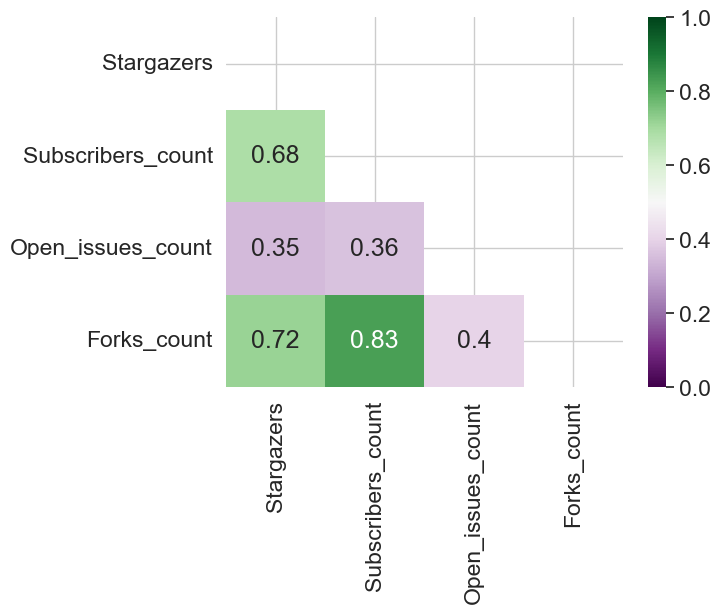

In [65]:
maturity = large_sample_metrics.get("maturity_level")
size_of_community = large_sample_metrics.get("size_of_community")
star_maturity_dict = {}
repo_list = []
star_list = []
sub_list = []
open_issues_list = []
forks_count_list = []
maturity_list = []
size_of_community_list = []
for repo, item in repository_dict_large.items():
    name = item.get("name")
    login = item.get("owner").get("login")
    repo_list.append((name + "_" + login))
    star_list.append(item.get("stargazers_count"))
    maturity_list.append(maturity.get(repo))
    size_of_community_list.append(size_of_community.get(repo))
    sub_list.append(item.get("subscribers_count"))
    open_issues_list.append(item.get("open_issues"))
    forks_count_list.append(item.get("forks_count"))
star_maturity_dict["Repository"] = repo_list
star_maturity_dict["Stargazers"] = star_list
star_maturity_dict["Subscribers_count"] = sub_list
star_maturity_dict["Open_issues_count"] = open_issues_list
star_maturity_dict["Forks_count"] = forks_count_list
df = pd.DataFrame.from_dict(star_maturity_dict)
df_corr_large_01 = df[["Stargazers", "Subscribers_count", "Open_issues_count", "Forks_count"]].corr(method="spearman")
matrix = np.triu(df_corr_small_01)
corr_fig = sns.heatmap(df_corr_large_01, cmap='PRGn', annot=True, mask=matrix, vmin=0, vmax=1)

plt.savefig("figures/large_overview_corr_fig.png", bbox_inches='tight')

# df = pd.melt(df, id_vars="Repository", var_name="Objective", value_name="Value")

### OSI approved license

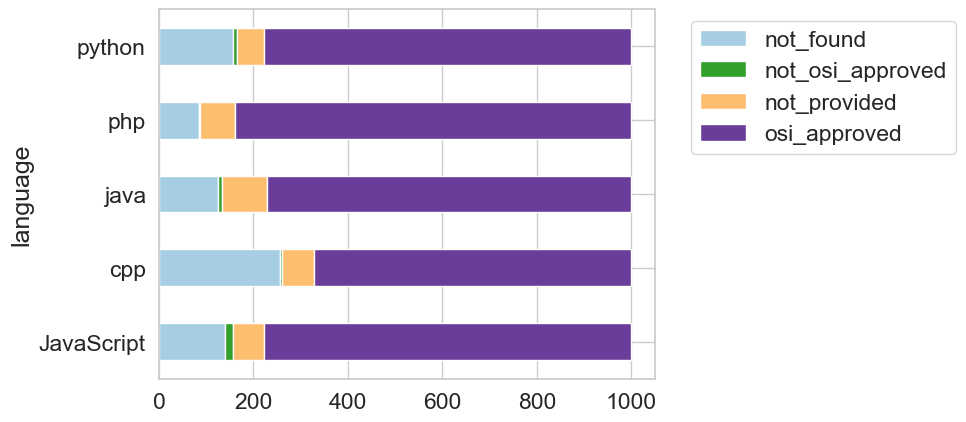

In [66]:
osi_large = large_sample_metrics[["language", "osi_approved_license"]]

osi_large_value_counts = osi_large.value_counts()
osi_large_value_counts = osi_large_value_counts.to_frame().reset_index()
osi_large_value_counts = osi_large_value_counts.pivot_table('count', ['language', 'osi_approved_license'], 'osi_approved_license').reset_index()# .drop(osi_large_value_counts.columns[:11], axis=1)
osi_large_value_counts = osi_large_value_counts.drop('osi_approved_license', axis=1)
osi_large_value_counts = osi_large_value_counts.groupby(['language']).sum()
osi_large_value_counts = osi_large_value_counts.reset_index()

osi_large_value_counts.set_index('language').plot(kind='barh', stacked=True, cmap=seaborn_colormap) ## Plot
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("figures/osi_large_value_counts.png", bbox_inches='tight')
osi_large_value_counts = osi_large_value_counts.astype({"not_found":"int","not_osi_approved":"int","not_provided":"int","osi_approved":"int"})
add_table_to_word(osi_large_value_counts)
time.sleep(3)

### Churn

In [67]:
churn_large = large_sample_metrics [["language", "churn"]]
churn_large_summary = churn_large.groupby("language").describe().transpose()

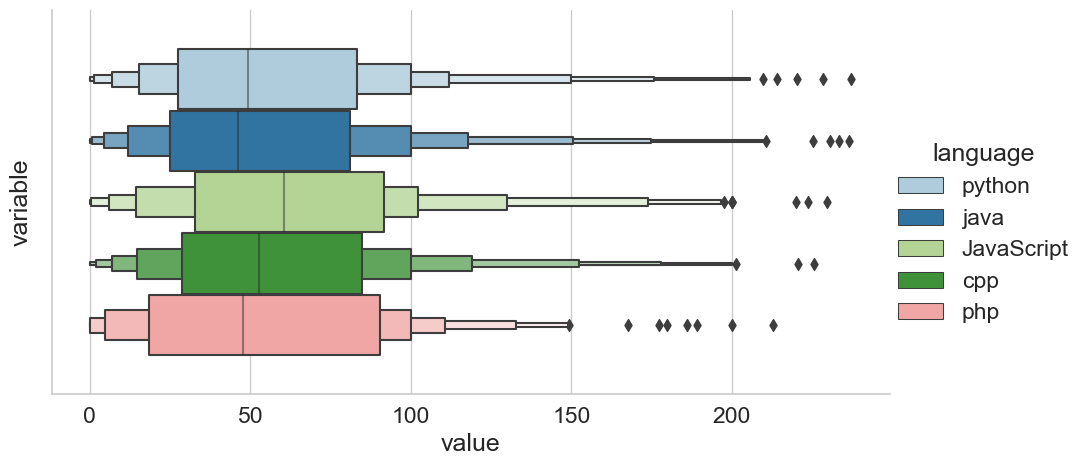

In [68]:
churn_large_all = large_sample_metrics [["language", "repository", "churn"]].sort_values("churn", ascending=False)
churn_large_box = churn_large_all [["language", "repository", "churn"]].sort_values("churn", ascending=False).iloc[100:]
churn_large_box = pd.melt(churn_large_box, id_vars=["language","repository"],
    value_vars=["churn"])
g1 = sns.catplot(data=churn_large_box, x="value", y="variable", kind="boxen", hue="language", palette = palette, height=5, aspect=2)
# sns.boxplot(y=df_churn_large_all['metric'], x=df_churn_large_all['Value'], hue=df_churn_large_all['language'], palette=palette, orient="h")
g1.set(yticklabels=[])
g1.savefig("figures/df_churn_large_grouped.png", bbox_inches='tight')

In [69]:
churn_large_top = churn_large_all.sort_values("churn", ascending=False).head(5).reset_index(drop=True)
add_table_to_word(churn_large_top)
time.sleep(3)

### Branches

In [70]:
branches_large = large_sample_metrics[["language","repository", "branch_lifecycle_branch_state_counter",
    "branch_lifecycle_branch_creation_frequency_days", "branch_lifecycle_branch_avg_age_days",
    "branch_lifecycle_stale_ratio", "branch_lifecycle_active_ratio", "branch_lifecycle_unresolved_ratio", "branch_lifecycle_resolved_ratio"]]
columns_new = ["language", "repository","branch_state_counter", "branch_creation_frequency_days",
"branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]

branches_large = branches_large.set_axis(columns_new, axis='columns')
branches_large_summary = branches_large.groupby("language").describe()
add_table_to_word(branches_large_summary)
time.sleep(3)
# branches_large_sample_summary = branches_large_sample_summary.reset_index().transpose()
# branches_large_sample_summary = branches_large_sample_summary.rename(columns=branches_large_sample_summary.iloc[0]).drop(advisories_large_sample_summary.index[0])
# branches_large_sample_summary.transpose().xs("count", level=1, axis=1)["patch_ratio"]

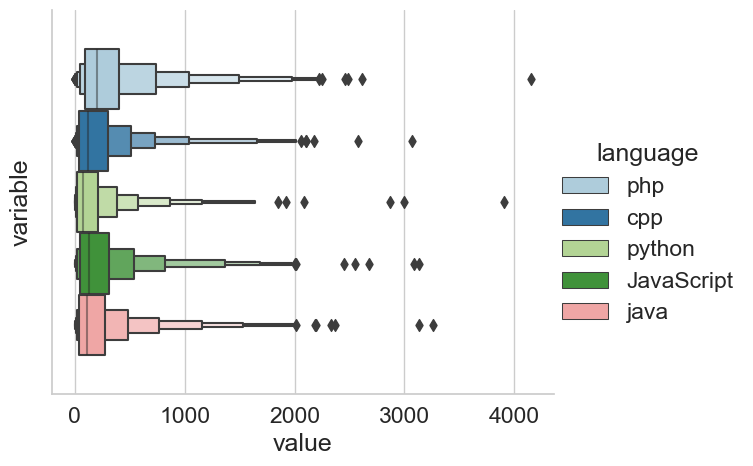

In [71]:
# churn_large_all = large_sample_metrics [["language", "repository", "churn"]].sort_values("churn", ascending=False).iloc[100:]
branches_large_box = pd.melt(branches_large, id_vars=["language","repository"],
    value_vars=["branch_creation_frequency_days"])
g1 = sns.catplot(data=branches_large_box, x="value", y="variable", kind="boxen", hue="language", palette = palette, height=5, aspect=2)
g1.set(yticklabels=[])
g1.savefig("figures/df_branch_creation_frequency_days_grouped.png", bbox_inches='tight')

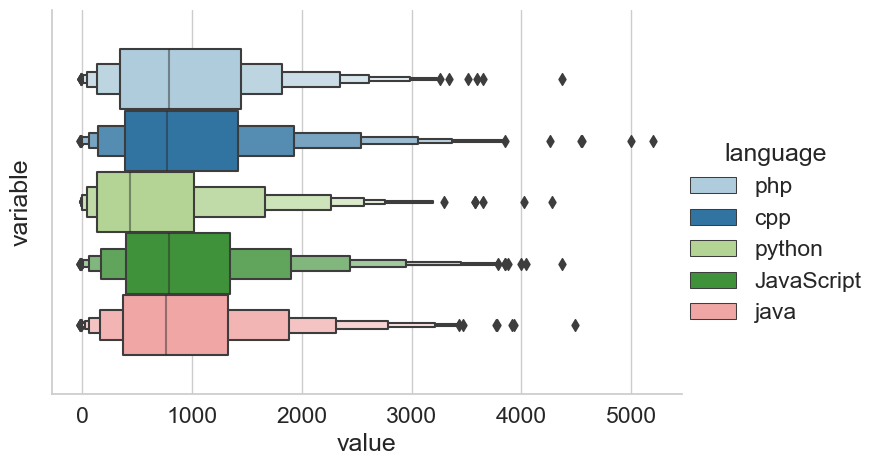

In [72]:
branches_large_box = pd.melt(branches_large, id_vars=["language","repository"],
    value_vars=["branch_avg_age_days"])
g1 = sns.catplot(data=branches_large_box, x="value", y="variable", kind="boxen", hue="language", palette = palette, height=5, aspect=2)
# sns.boxplot(y=df_churn_large_all['metric'], x=df_churn_large_all['Value'], hue=df_churn_large_all['language'], palette=palette, orient="h")
g1.set(yticklabels=[])
g1.savefig("figures/df_branch_avg_age_days_grouped.png", bbox_inches='tight')

In [73]:
branches_large_python = branches_large[branches_large["language"] == 'python'][["language", "repository","branch_creation_frequency_days"]][:300].reset_index(drop=True).reset_index()
branches_large_php = branches_large[branches_large["language"] == 'php'][["language", "repository","branch_creation_frequency_days"]][:300].reset_index(drop=True).reset_index()
branches_large_java = branches_large[branches_large["language"] == 'java'][["language", "repository","branch_creation_frequency_days"]][:300].reset_index(drop=True).reset_index()
branches_large_java_script = branches_large[branches_large["language"] == 'JavaScript'][["language", "repository","branch_creation_frequency_days"]][:300].reset_index(drop=True).reset_index()
branches_large_cpp = branches_large[branches_large["language"] == 'cpp'][["language", "repository","branch_creation_frequency_days"]][:300].reset_index(drop=True).reset_index()
top_repos = pd.concat([
branches_large_python,
branches_large_php,
branches_large_java,
branches_large_java_script,
branches_large_cpp
])

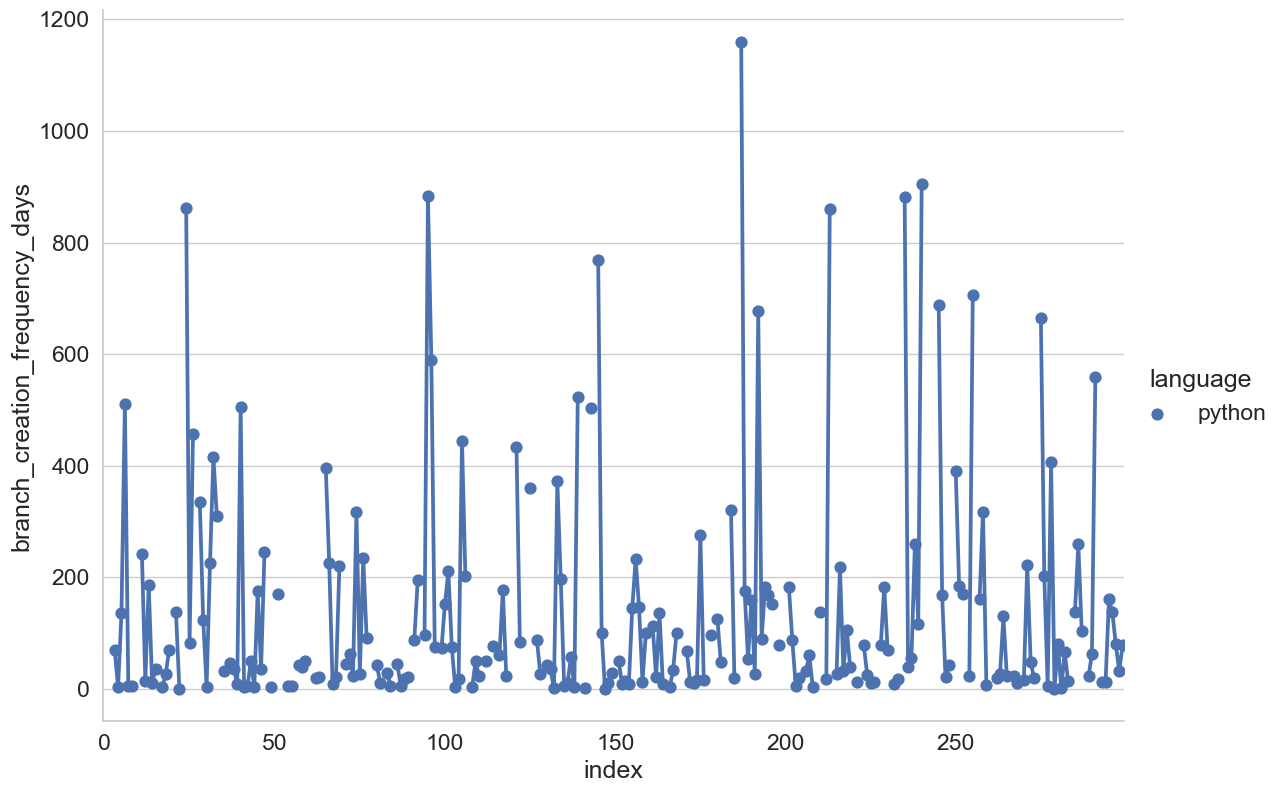

In [74]:
g1 = sns.catplot(
    data=branches_large_python, x="index", y="branch_creation_frequency_days",
    hue="language",
    kind="point", height=8.27, aspect=11.7/8.27
)
g1.set(xticks=branches_large_python.index[0::50])
g1.savefig("figures/branches_large_python_300.png", bbox_inches='tight')

### Contributions Distributions

In [75]:
cont_dib_large = large_sample_metrics[["language", "repository","contributions_distributions_bus_factor_score", "elephant_factor",
"contributions_distributions_RoF_tail", "contributions_distributions_RoF_dominant",
"contributions_distributions_RoF_diff_percent", "contributions_distributions_avg_num_contributors_per_file",
                                    "contributions_distributions_NoC_tail",
                                    "contributions_distributions_NoC_dominant", "contributions_distributions_NoC_diff_percent"]]
columns_new = ["language", "repository", "bus_factor", "elephant_factor", "RoF_tail", "RoF_dominant", "RoF_diff_percent", "avg_num_contributors_per_file",
                                     "NoC_tail", "NoC_dominant", "NoC_diff_percent"]
cont_dib_large.columns = columns_new
cont_dib_large_summary = cont_dib_large.groupby("language").describe().transpose()
add_table_to_word(cont_dib_large_summary)
time.sleep(3)

In [117]:
cont_scores = cont_dib_large[["language","repository","bus_factor", "elephant_factor"]]
cont_pareto_diffs = cont_dib_large[["language","repository","RoF_dominant", "NoC_dominant"]]
cont_avg_num_contrib = cont_dib_large[["language","repository","avg_num_contributors_per_file"]]

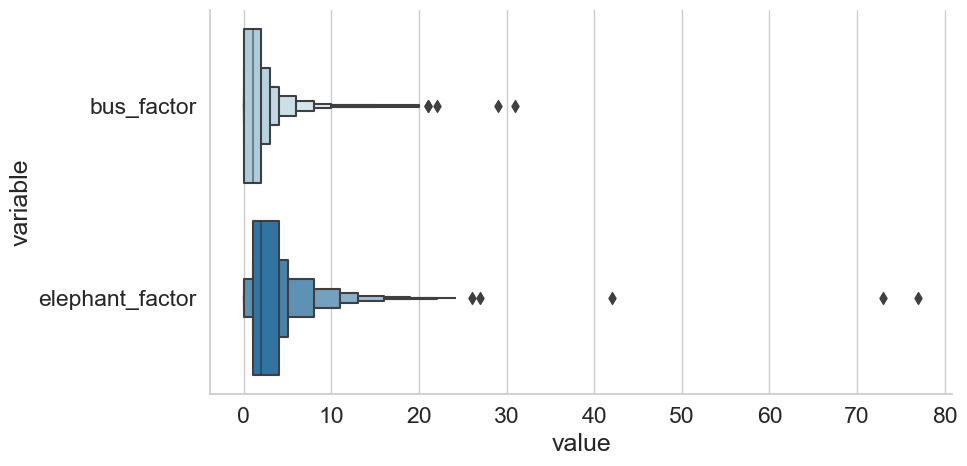

In [118]:
df_contrib_scores_large = pd.melt(cont_scores, id_vars=["language"],
    value_vars=["bus_factor","elephant_factor"])

sns.catplot(data=df_contrib_scores_large, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/df_contrib_scores_large.png", bbox_inches='tight')

In [78]:
cont_scores.sort_values("elephant_factor", ascending=False).head()

,language,repository,bus_factor,elephant_factor
3029,JavaScript,gatsby_gatsbyjs,4.000,77
2151,python,dash_plotly,1.000,73
133,php,web-frameworks_the-benchmarker,1.000,42
2646,python,sh_amoffat,0.000,27
543,php,php-github-api_KnpLabs,NaN,26


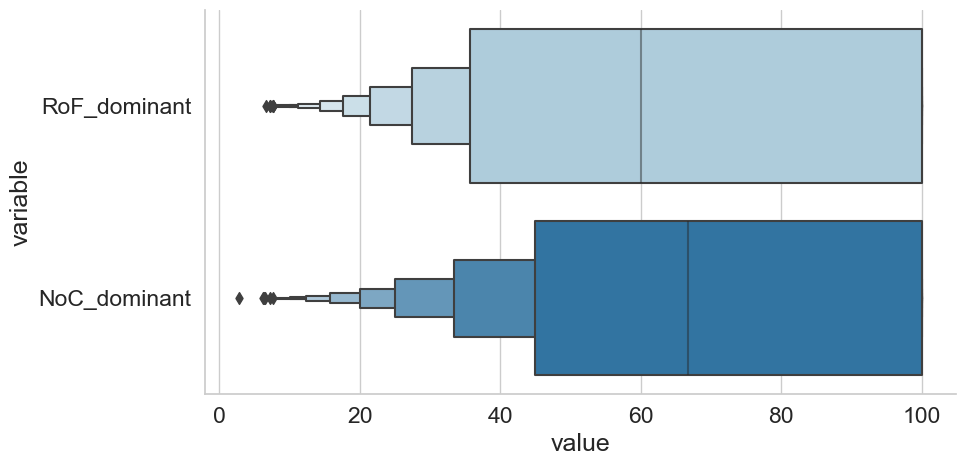

In [120]:
df_cont_pareto_diffs_large = pd.melt(cont_pareto_diffs, id_vars=["language"],
    value_vars=["RoF_dominant", "NoC_dominant"])

sns.catplot(data=df_cont_pareto_diffs_large, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/df_cont_pareto_diffs_large.png", bbox_inches='tight')

In [80]:
cont_avg_num_contrib_summary = cont_avg_num_contrib.groupby("language").describe()
cont_avg_num_contrib_summary_mean = cont_avg_num_contrib_summary.iloc[:, cont_avg_num_contrib_summary.columns.get_level_values(1)=="mean"].reset_index()
cont_avg_num_contrib_summary_min = cont_avg_num_contrib_summary.iloc[:, cont_avg_num_contrib_summary.columns.get_level_values(1)=="min"].reset_index()
cont_avg_num_contrib_summary_max = cont_avg_num_contrib_summary.iloc[:, cont_avg_num_contrib_summary.columns.get_level_values(1)=="max"].reset_index()
cont_avg_num_contrib_summary_cut = pd.concat([
cont_avg_num_contrib_summary_mean,
cont_avg_num_contrib_summary_min,
cont_avg_num_contrib_summary_max
]).groupby("language").sum()
add_table_to_word(cont_avg_num_contrib_summary_cut)
time.sleep(3)

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\997955807.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  cont_avg_num_contrib_summary_cut = pd.concat([


In [122]:
cont_avg_num_contrib_summary_cut

avg_num_contributors_per_file             
                                    mean   min    max
language                                             
JavaScript                         1.496 1.000 21.662
cpp                                1.309 1.000  5.415
java                               1.368 1.000 23.070
php                                1.360 1.000  6.793
python                             1.658 1.000 32.857

In [81]:
cont_avg_num_contrib_top_ten = cont_avg_num_contrib.sort_values(by="avg_num_contributors_per_file", ascending=False).head(10).reset_index(drop=True)
add_table_to_word(cont_avg_num_contrib_top_ten)
time.sleep(3)

### Security Advisories

In [82]:
large_sample_metrics.columns

Index(['repository', 'maturity_level', 'osi_approved_license',
       'criticality_score', 'technical_fork_total_forks',
       'technical_fork_average_forks_created_per_week',
       'pull_requests_total_pulls', 'pull_requests_avg_pull_closing_days',
       'pull_requests_ratio_open_total', 'pull_requests_ratio_closed_total',
       'pull_requests_ratio_merged_total', 'project_velocity_total_issues',
       'project_velocity_closed_issues', 'project_velocity_open_issues',
       'project_velocity_pull_count', 'project_velocity_no_pull_count',
       'project_velocity_ratio_pull_issue',
       'project_velocity_avg_issue_resolving_days',
       'project_velocity_ratio_open_total',
       'project_velocity_ratio_closed_total',
       'github_community_health_percentage_community_health_score',
       'github_community_health_percentage_custom_health_score',
       'github_community_health_percentage_true_count',
       'github_community_health_percentage_false_count',
       'github_com

In [83]:
advisories_large_sample = large_sample_metrics [["language", "security_advisories_advisories_available", "security_advisories_patch_ratio",
"security_advisories_closed_advisories", "security_advisories_average_cvss_score", "security_advisories_ratio_severity_high_crit"]]
advisories_large_sample.columns = ["language", "advisories_available", "patch_ratio",
"closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]
advisories_large_sample_summary = advisories_large_sample.groupby("language").describe()
advisories_count = advisories_large_sample_summary.iloc[:, advisories_large_sample_summary.columns.get_level_values(1)== "count"].transpose()
advisories_mean = advisories_large_sample_summary.iloc[:, advisories_large_sample_summary.columns.get_level_values(1)== "mean"].transpose()
advisories_summary_short = pd.concat([advisories_count, advisories_mean])
add_table_to_word(advisories_summary_short)
time.sleep(3)

### Code Dependency

In [84]:
large_sample_dependencies = large_sample_metrics[["language", "code_dependency_total_upstream", "code_dependency_total_downstream"]]
large_dependencies_summary = large_sample_dependencies.groupby("language").describe().transpose()
# add_table_to_word(large_dependencies_summary)
# time.sleep(3)

In [85]:
def label_dependencies(row):
   if row['code_dependency_total_upstream'] == 0 and row['code_dependency_total_downstream'] == 0:
      return 'no dependencies'
   if row['code_dependency_total_upstream'] > 0 or row['code_dependency_total_downstream'] > 0:
      return 'dependencies'
   return "no data"

In [86]:
def label_dependencies(row):
   if row['code_dependency_total_upstream'] == 0:
      return 'no upstream dependencies'
   if row['code_dependency_total_downstream'] == 0:
      return 'no downstream dependencies'
   if row['code_dependency_total_upstream'] > 0 and row['code_dependency_total_downstream'] > 0:
      return 'all dependencies available'
#    if row['code_dependency_total_upstream'] > 0 or row['code_dependency_total_downstream'] > 0:
#       return 'dependencies'
   return "no data"

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\2990677945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_sample_dependencies["Dependencies_available"] = large_sample_dependencies.apply (lambda row: label_dependencies(row), axis=1)


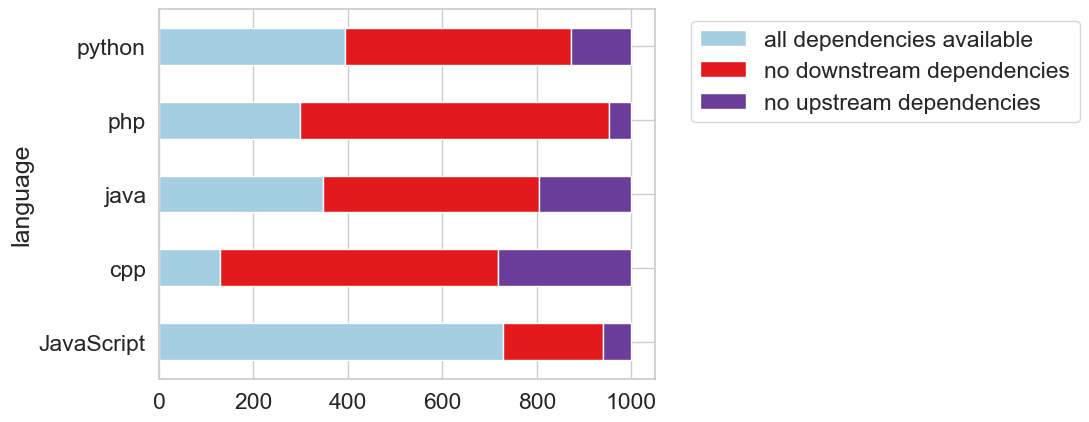

In [87]:
large_sample_dependencies["Dependencies_available"] = large_sample_dependencies.apply (lambda row: label_dependencies(row), axis=1)
df_large_sample_dependencies = large_sample_dependencies[["language", "Dependencies_available"]].groupby(["language", "Dependencies_available"]).size().to_frame().reset_index()
df_large_sample_dependencies = df_large_sample_dependencies.pivot(index='language', columns='Dependencies_available', values=0).reset_index()
df_large_sample_dependencies.set_index('language').plot(kind='barh', stacked=True, cmap=seaborn_colormap) ## Plot
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("figures/df_large_sample_dependencies.png", bbox_inches='tight')

In [88]:
large_sample_dependencies

,language,code_dependency_total_upstream,code_dependency_total_downstream,Dependencies_available
0,php,20,1981,all dependencies available
1,php,4,0,no downstream dependencies
2,php,92,1732982,all dependencies available
3,php,263,73093,all dependencies available
4,php,95,80716,all dependencies available
5,php,2142,0,no downstream dependencies
6,php,24,1424434,all dependencies available
7,php,68,0,no downstream dependencies
8,php,64,0,no downstream dependencies
9,php,26,2015042,all dependencies available


### Issues

In [89]:
large_sample_issues = large_sample_metrics [["language", "issues_open_issues", "issues_closed_issues", "issues_new_issues", "issues_new_ratio",
    "issues_average_issues_created_per_week", "issues_average_issue_comments", "issues_average_issue_resolving_days",
              "issues_average_first_response_time_days", "issues_ratio_open_total", "issues_ratio_closed_total"]]
columns_new = ["language", "open_issues", "closed_issues", "new_issues", "new_ratio",
"average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]
large_sample_issues = large_sample_issues.set_axis(columns_new, axis='columns')

large_issues_summary = large_sample_issues.groupby("language").describe().transpose()
# add_table_to_word(large_issues_summary)
# time.sleep(3)

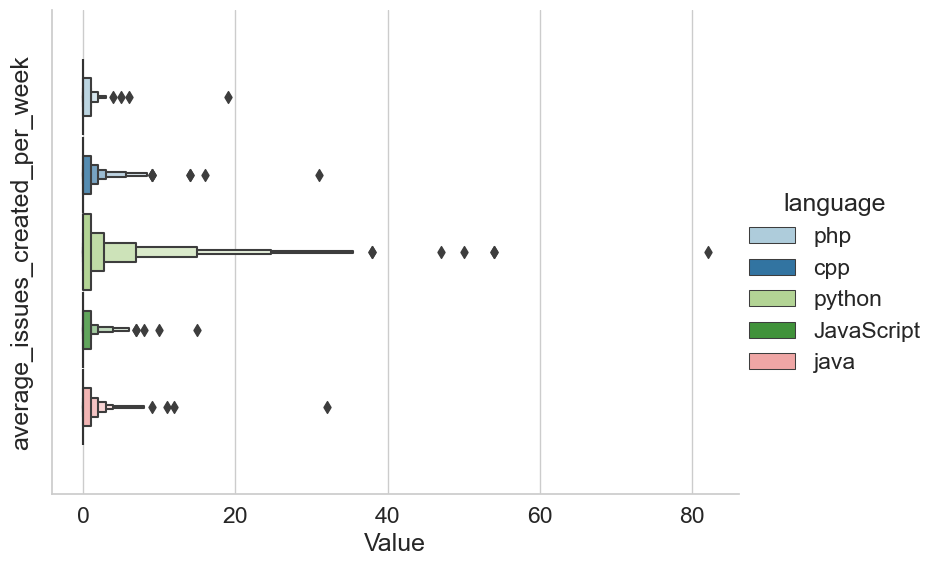

In [90]:
large_sample_issues_new_issues = large_sample_issues[["language", "average_issues_created_per_week"]]
# sns.catplot(data=large_sample_issues_new_issues, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)

df_large_sample_issues_new_issues = large_sample_issues_new_issues.melt(id_vars=["language"], 
        var_name="average_issues_created_per_week", 
        value_name="Value").dropna()
fig = sns.catplot(data=df_large_sample_issues_new_issues, x="Value", y="average_issues_created_per_week", kind="boxen", hue='language', palette = palette, height=6, aspect=2)
fig.set(yticklabels=[])

plt.savefig("figures/df_large_sample_issues_new_issues.png", bbox_inches='tight')

### Community Health Score

In [91]:
health_large_sample = large_sample_metrics [["language", "github_community_health_percentage_community_health_score","github_community_health_percentage_custom_health_score",
"github_community_health_percentage_true_count", "github_community_health_percentage_false_count", "github_community_health_percentage_description",
"github_community_health_percentage_documentation", "github_community_health_percentage_code_of_conduct",
"github_community_health_percentage_contributing", "github_community_health_percentage_issue_template", "github_community_health_percentage_pull_request_template",
"github_community_health_percentage_license", "github_community_health_percentage_readme"]]

health_large_sample = health_large_sample[["language", "github_community_health_percentage_community_health_score","github_community_health_percentage_custom_health_score"]]
health_large_sample.columns = ["language", "percentage_community_health_score","percentage_custom_health_score"]
health_large_summary = health_large_sample.describe().transpose()
add_table_to_word(health_large_summary)

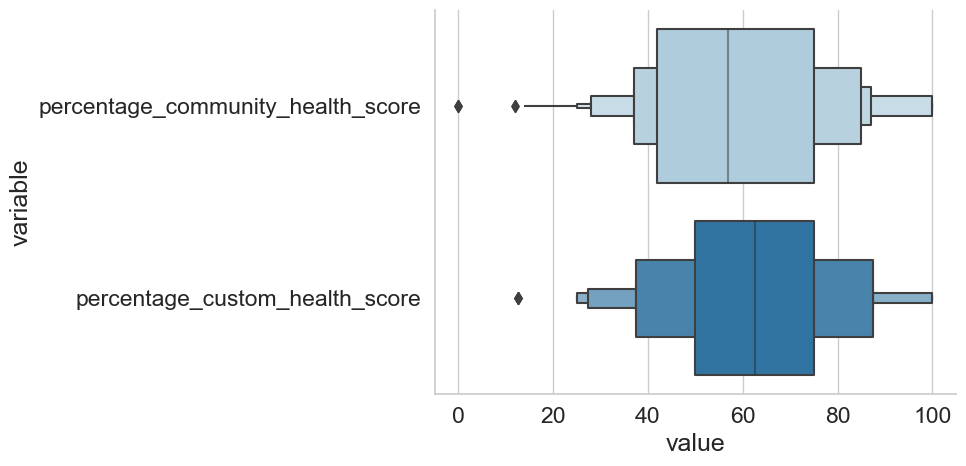

In [92]:
df_health_large_sample_temp = pd.melt(health_large_sample, id_vars=["language"],
    value_vars=["percentage_community_health_score","percentage_custom_health_score"])

sns.catplot(data=df_health_large_sample_temp, x="value", y="variable", kind="boxen", palette = palette, height=5, aspect=2)
plt.savefig("figures/df_health_large_sample_temp.png", bbox_inches='tight')

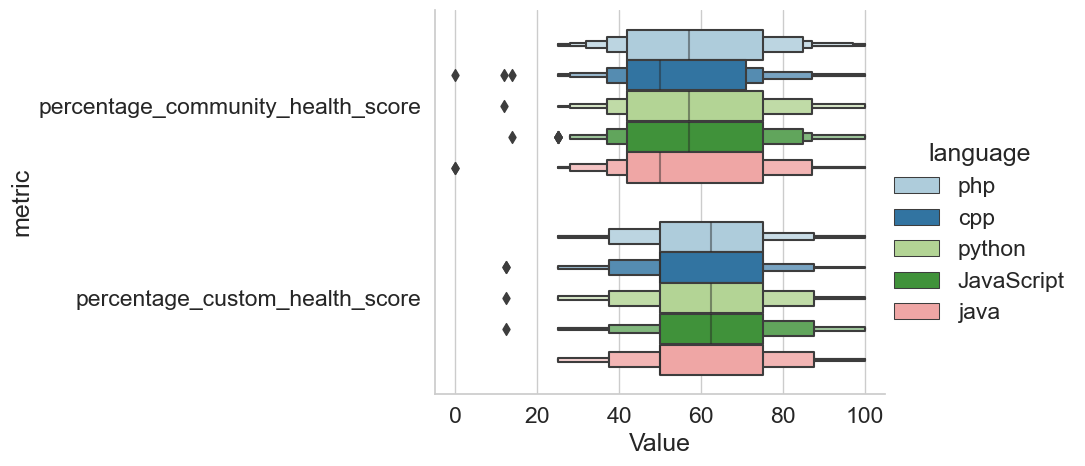

In [93]:
health_large_sample = large_sample_metrics[["repository","language", "github_community_health_percentage_community_health_score","github_community_health_percentage_custom_health_score"]]
health_large_sample.columns = ["repository","language", "percentage_community_health_score","percentage_custom_health_score"]
df_health_large_sample_temp = health_large_sample.melt(id_vars=["repository", "language"], 
        var_name="metric", 
        value_name="Value")

sns.catplot(data=df_health_large_sample_temp, x="Value", y="metric", kind="boxen", hue='language', palette = palette, height=5, aspect=2)
plt.savefig("figures/df_health_large_sample.png", bbox_inches='tight')

In [94]:
def highlight_greaterthan(s, threshold, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: 	#7FFFD4' if is_max.any() else '' for v in is_max]

In [95]:
df_health_details = large_sample_metrics[["language", 
"github_community_health_percentage_documentation", "github_community_health_percentage_code_of_conduct", "github_community_health_percentage_description",
"github_community_health_percentage_contributing", "github_community_health_percentage_issue_template", "github_community_health_percentage_pull_request_template",
"github_community_health_percentage_license", "github_community_health_percentage_readme"]]
doc = df_health_details.groupby(["language"])[["github_community_health_percentage_documentation"]].value_counts().to_frame()
doc["detail"] = "documentation"
coc = df_health_details.groupby(["language"])[["github_community_health_percentage_code_of_conduct"]].value_counts().to_frame()
coc["detail"] = "code_of_conduct"
cont = df_health_details.groupby(["language"])[["github_community_health_percentage_contributing"]].value_counts().to_frame()
cont["detail"] = "contributing"
ist = df_health_details.groupby(["language"])[["github_community_health_percentage_issue_template"]].value_counts().to_frame()
ist["detail"] = "issue_template"
put = df_health_details.groupby(["language"])[["github_community_health_percentage_pull_request_template"]].value_counts().to_frame()
put["detail"] = "pull_request_template"
li = df_health_details.groupby(["language"])[["github_community_health_percentage_license"]].value_counts().to_frame()
li["detail"] = "license"
re = df_health_details.groupby(["language"])[["github_community_health_percentage_readme"]].value_counts().to_frame()
re["detail"] = "readme"
desc = df_health_details.groupby(["language"])[["github_community_health_percentage_description"]].value_counts().to_frame()
desc["detail"] = "description"

health_concat = pd.concat(
    [doc,
    coc,
    cont,
    ist,
    put,
    li,
    re,
    desc]
    ).reset_index()
health_concat = health_concat[['language', 'detail', 'level_1', 'count']]
health_concat.columns = ['language', 'detail', 'available', 'count']
health_concat = health_concat.sort_values(["language", "detail"]).reset_index(drop=True)

health_concat = health_concat.loc[health_concat['count'] >= 950]
add_table_to_word(health_concat)
time.sleep(3)
# df_health_details.describe(include='object')

### Project Velocity

In [96]:
def label_pulls (row):
   if row['no_pull_count'] == 0:
      return 'no Issues'
   if row['no_pull_count'] > 0:
      return 'Issues'
   return "no data"

In [97]:
large_sample_project_velocity = large_sample_metrics[["language", "project_velocity_total_issues", "project_velocity_closed_issues", "project_velocity_open_issues",
                                                      "project_velocity_pull_count", "project_velocity_no_pull_count", "project_velocity_ratio_pull_issue",
                                                      "project_velocity_avg_issue_resolving_days", "project_velocity_ratio_open_total", "project_velocity_ratio_closed_total"]]
new_columns = ["language", "total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]
large_sample_project_velocity.columns = new_columns
large_project_velocity_summary = large_sample_project_velocity.groupby("language").describe().transpose()
add_table_to_word(large_project_velocity_summary)
time.sleep(3)

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\3137119736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_sample_project_velocity["Pulls_available"] = large_sample_project_velocity.apply (lambda row: label_pulls(row), axis=1)


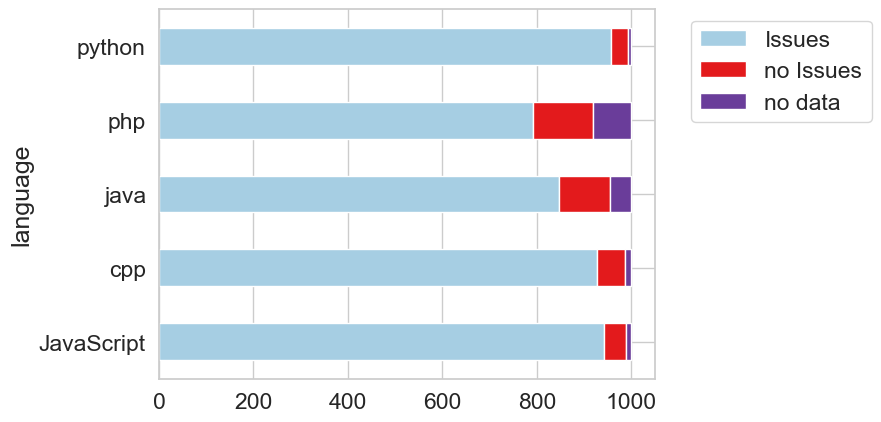

In [98]:
large_sample_project_velocity["Pulls_available"] = large_sample_project_velocity.apply (lambda row: label_pulls(row), axis=1)
df_large_sample_project_velocity_plot = large_sample_project_velocity[["language", "Pulls_available"]].groupby(["language", "Pulls_available"]).size().to_frame().reset_index()
df_large_sample_project_velocity_plot = df_large_sample_project_velocity_plot.pivot(index='language', columns='Pulls_available', values=0).reset_index()
df_large_sample_project_velocity_plot.set_index('language').plot(kind='barh', stacked=True, cmap=seaborn_colormap) ## Plot
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("figures/df_large_sample_project_velocity_plot.png", bbox_inches='tight')

### Pull Requests

In [99]:
large_sample_pulls = large_sample_metrics[["language", "pull_requests_total_pulls",
    "pull_requests_avg_pull_closing_days", "pull_requests_ratio_open_total", "pull_requests_ratio_closed_total", "pull_requests_ratio_merged_total"]]
large_pulls_summary = large_sample_pulls.groupby("language").describe().transpose()
add_table_to_word(large_pulls_summary)
time.sleep(3)

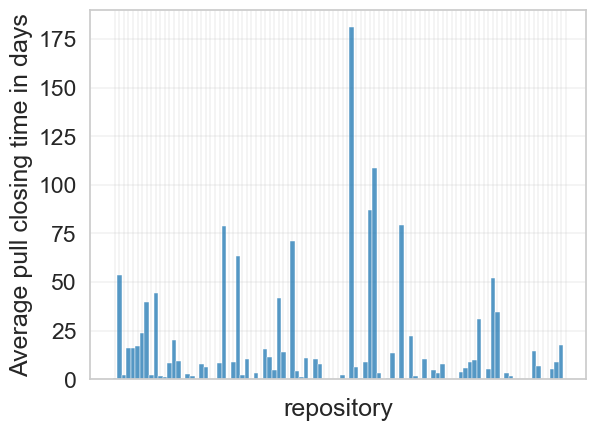

<Figure size 640x480 with 0 Axes>

In [100]:
large_sample_pulls = large_sample_metrics[["repository", "language", "pull_requests_avg_pull_closing_days"]][:100]
df_large_sample_pulls_python = large_sample_pulls.melt(id_vars=["repository", "language"], 
        var_name="metric",
        value_name="Value")
ax = sns.histplot(df_large_sample_pulls_python, x='repository', weights='Value', multiple='stack', legend=False, color=palette.as_hex()[1])
ax.set(ylabel='Average pull closing time in days')
ax.set(xticklabels=[])
ax.grid(linewidth=0.3)
plt.show()
plt.savefig("figures/df_large_sample_pulls_avg_pull_closing_days_python.png", bbox_inches='tight')

In [101]:
large_sample_pulls_summary = large_sample_metrics.groupby('language')[['pull_requests_avg_pull_closing_days']].describe().reset_index()
add_table_to_word(large_sample_pulls_summary)
time.sleep(3)

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\3237844887.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.histplot(df_large_sample_pulls_python, x='index', hue='metric', weights='Value', multiple='stack', palette=palette)
c:\Users\Jacky\anaconda3\envs\mdi_py38_jupyter\lib\site-packages\seaborn\distributions.py:416: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


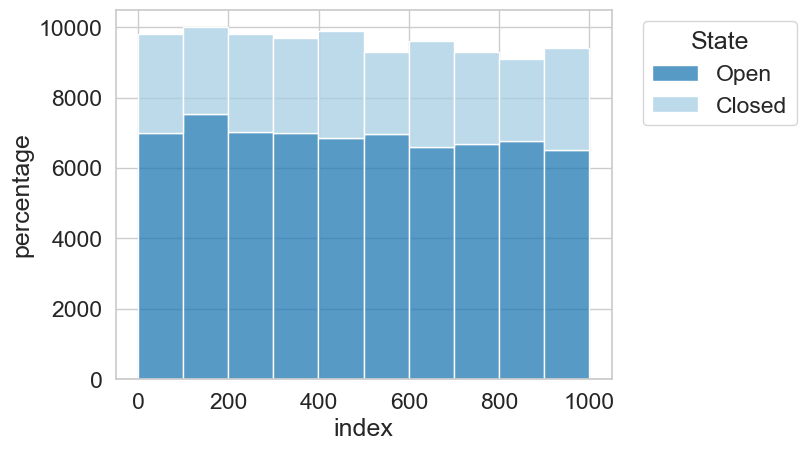

<Figure size 640x480 with 0 Axes>

In [102]:
df_large_sample_pulls_python = large_sample_metrics[large_sample_metrics["language"] == 'python'][["repository", "language", "pull_requests_ratio_open_total", "pull_requests_ratio_closed_total"]].reset_index(drop=True).reset_index()
df_large_sample_pulls_python = df_large_sample_pulls_python.melt(id_vars=["repository", "language", "index"], 
        var_name="metric",
        value_name="Value")
ax = sns.histplot(df_large_sample_pulls_python, x='index', hue='metric', weights='Value', multiple='stack', palette=palette)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="State", labels=['Open', 'Closed'])
ax.set(ylabel='percentage')
plt.show()
plt.savefig("figures/df_large_sample_pulls_python.png", bbox_inches='tight')

### Technical Forks

In [103]:
large_sample_forks = large_sample_metrics[["language", "technical_fork_total_forks", "technical_fork_average_forks_created_per_week"]]

large_forks_summary = large_sample_forks.groupby("language").describe().transpose()
add_table_to_word(large_forks_summary)
time.sleep(3)

In [104]:
large_forks_filt_summary = large_sample_forks.groupby('language')[['technical_fork_average_forks_created_per_week']].describe().reset_index()
add_table_to_word(large_forks_filt_summary)
time.sleep(3)

In [105]:
large_sample_forks_repos = large_sample_metrics[["language", "repository", "technical_fork_average_forks_created_per_week", "technical_fork_total_forks", ]]
large_sample_forks_repos['language'] = large_sample_forks_repos['language'].str.strip()
options = ['python']
large_sample_forks_python = large_sample_forks_repos.loc[large_sample_forks_repos['language'].isin(options)] 
large_sample_forks_python = large_sample_forks_python.sort_values('technical_fork_average_forks_created_per_week', ascending=False).head(10).reset_index(drop=True)
large_sample_forks_python.columns = ["language", "repository", "average_forks_created_per_week", "total_forks"]
add_table_to_word(large_sample_forks_python)
time.sleep(3)

C:\Users\Jacky\AppData\Local\Temp\ipykernel_12920\4068511191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_sample_forks_repos['language'] = large_sample_forks_repos['language'].str.strip()


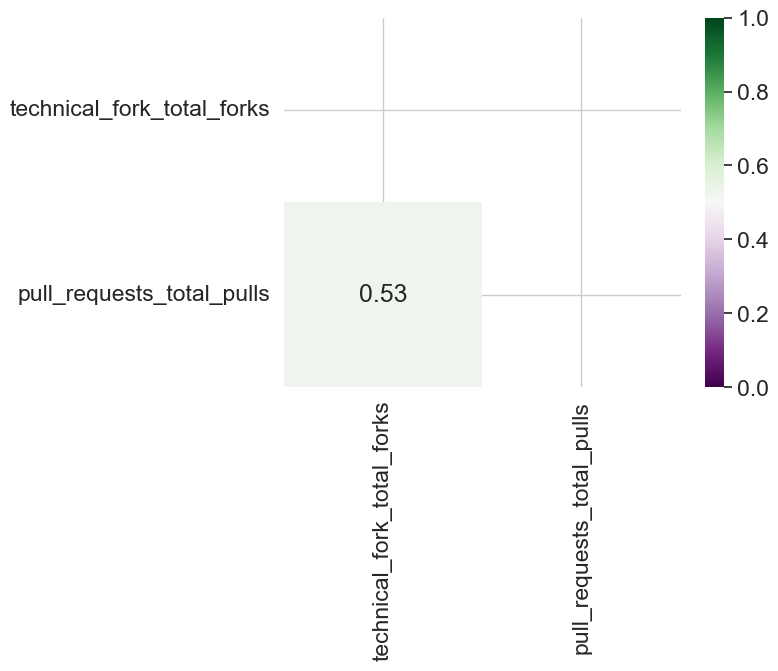

In [106]:
df_forks_pulls_large = large_sample_metrics[["repository","technical_fork_total_forks", "pull_requests_total_pulls"]]

df_forks_pulls_large_corr = df_forks_pulls_large.drop('repository', axis=1).corr(method="spearman")
add_table_to_word(df_forks_pulls_large_corr)
time.sleep(3)
matrix = np.triu(df_forks_pulls_large_corr)
corr_fig = sns.heatmap(df_forks_pulls_large_corr, cmap='PRGn', annot=True, mask=matrix, vmin=0, vmax=1)
plt.savefig("figures/df_forks_pulls_large_corr.png", bbox_inches='tight')

<Axes: >

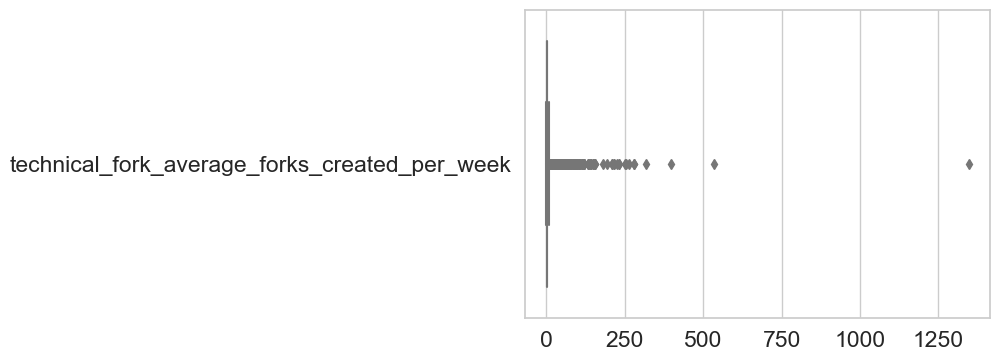

In [107]:
large_fork_days = large_sample_metrics[["language","repository","technical_fork_average_forks_created_per_week"]]
# temp[["technical_fork_total_forks", "pull_requests_total_pulls", "technical_fork_average_forks_created_per_week"]].corr()
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=large_fork_days, palette=palette, orient="h")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=350, horizontalalignment='right')
# plt.savefig("df_large_fork_pull_days.png", bbox_inches='tight')

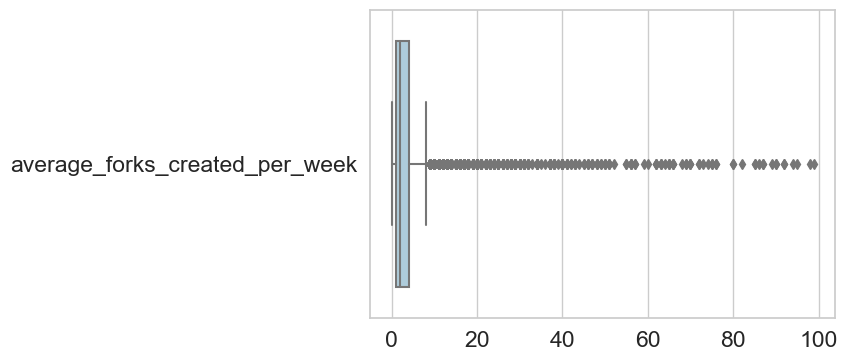

In [108]:
large_fork_days = large_sample_metrics[["language","repository","technical_fork_average_forks_created_per_week"]]
large_fork_days_filt = large_fork_days.loc[large_fork_days["technical_fork_average_forks_created_per_week"] <= 100]
large_fork_days_filt.columns = ["language","repository","average_forks_created_per_week"]
# temp[["technical_fork_total_forks", "pull_requests_total_pulls", "technical_fork_average_forks_created_per_week"]].corr()
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=large_fork_days_filt, palette=palette, orient="h")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=350, horizontalalignment='right')
plt.savefig("figures/df_large_fork_pull_days.png", bbox_inches='tight')

### Scores

In [109]:
large_sample_scores = large_sample_metrics[["repository", "language", "maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]]

large_scores_summary = large_sample_scores.groupby("language").describe().transpose()
add_table_to_word(large_scores_summary)
# large_pulls_summary
large_sample_scores.head()

,repository,language,maturity_level,support_rate,number_of_support_contributors,size_of_community,criticality_score
0,laravel_laravel,php,86.667,32.353,20.000,100.000,67.000
1,SecLists_danielmiessler,php,93.333,66.111,60.000,100.000,48.000
2,framework_laravel,php,73.333,3.137,40.000,100.000,90.000
3,symfony_symfony,php,73.333,1.843,100.000,100.000,87.000
4,composer_composer,php,86.667,32.358,20.000,100.000,77.000


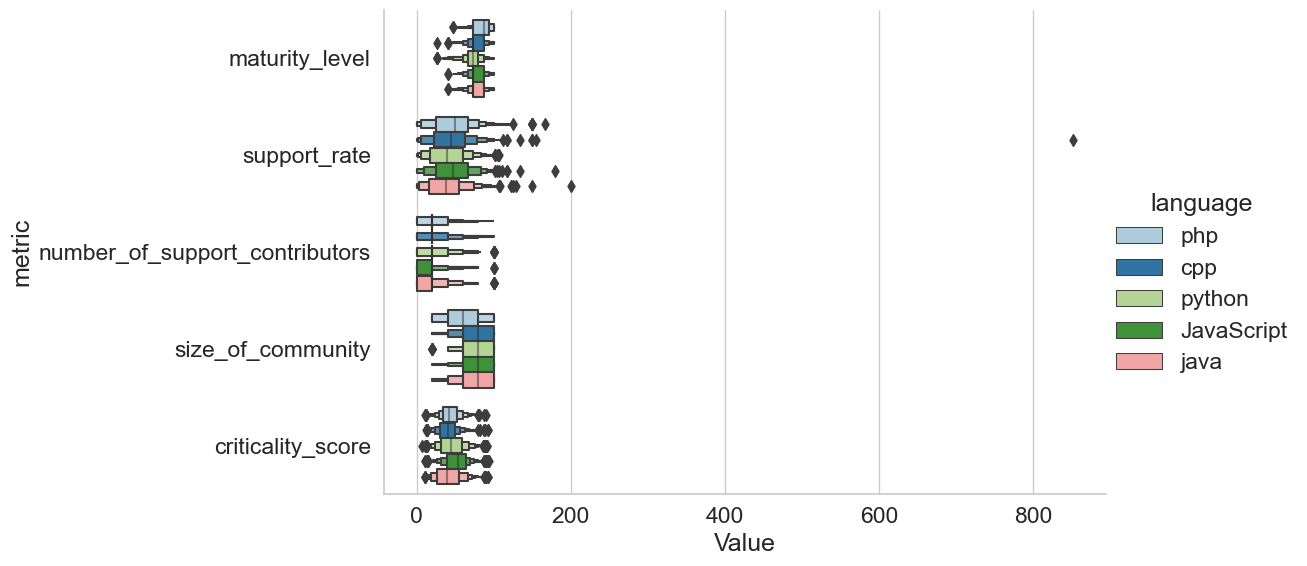

In [110]:
df_large_sample_scores = large_sample_scores.melt(id_vars=["repository", "language"], 
        var_name="metric", 
        value_name="Value").dropna()

# sns.boxplot(y=df_large_sample_scores['metric'], x=df_large_sample_scores['Value'], hue=df_large_sample_scores['language'], palette=palette, orient="h")
sns.catplot(data=df_large_sample_scores, x="Value", y="metric", kind="boxen", hue='language', palette = palette, height=6, aspect=2)


# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=350, horizontalalignment='right')
plt.savefig("figures/df_large_sample_scores.png", bbox_inches='tight')


In [111]:
# sns.barplot(data=advisories_large_sample_summary, x="osi_approved_license", order=tmp_df.osi_approved_license.value_counts().index, hue=tmp_df.language, palette=palette)

### Statistic Summary Complete

In [112]:
# large_summary = pd.concat([

# churn_large_summary,
# branches_large_summary,
# cont_dib_large_summary,
# advisories_large_sample_summary,
# large_dependencies_summary,
# large_issues_summary,
# health_large_summary,
# large_project_velocity_summary,
# large_pulls_summary,
# large_forks_summary,
# large_sample_scores
# ])
# add_table_to_word(large_summary)

In [113]:

# parent_dir = os.path.abspath('..')
# if parent_dir not in sys.path:
#     sys.path.append(parent_dir)

# combined_dict = {}
# path = os.path.join(parent_dir,"outputs", "data")
# for filename in os.listdir(path):
#     objective = filename.split(".")[0].split("_", 1)[1]
#     language = filename.split("_")[0]
#     file_path = os.path.join(path,filename)
#     tmp_dict = json_to_dict(path=file_path)
#     lang_dict = {}
#     lang_dict[language] = tmp_dict
#     if objective in combined_dict:
#         combined_dict[objective].update(lang_dict)
#     else:
#         combined_dict[objective] = lang_dict

In [114]:
# statistics = {}
# fields = ['Objective', 'Language', 'Information', 'Value']
# csv_filename = "statistics.csv"
# with open(csv_filename, 'w') as csvfile:
#     # creating a csv writer object 
#     csvwriter = csv.writer(csvfile)
#     # writing the fields 
#     csvwriter.writerow(fields) 
#     for objective, language in combined_dict.items():
#         for lang, data in language.items():
#             print(objective)
#             repo_num = len(data)
#             tmp_statistics = {"Repository number": repo_num}
#             print(objective)
#             print(language)
#             row = [objective, lang, "Repository number", str(repo_num)]
#             csvwriter.writerows([row])
#             if objective in ["active_branches", "stale_branches", "advisories", "commits", "contributors", "forks", "issue", "pull_requests", "release", "single_commits", "upstream_dependencies"]:
#                 min_num = 0
#                 max_num = 0
#                 for repo, values in data.items():
#                     if len(values) > max_num:
#                         max_num = len(values)
#                     elif min_num == 0:
#                         min_num = len(values)
#                     elif min_num > 0 and len(values) < min_num:
#                         min_num = len(values)
#                 row = [objective, lang, "Min oject number", str(min_num)]
#                 csvwriter.writerows([row])
#                 row = [objective, lang, "Max object number", str(max_num)]
#                 csvwriter.writerows([row])     
#             elif objective in ["community_health", "repository"]:
#                 num_with_keys = 0
#                 num_without_keys = 0
#                 for repo, values in data.items():
#                     first_key = list(values.keys())[0]
#                     if first_key:
#                         num_with_keys += 1
#                     else:
#                         num_without_keys += 1
#                 row = [objective, lang, "Objects with keys", str(num_with_keys)]
#                 csvwriter.writerows([row])  
#                 row = [objective, lang, "Objects without keys", str(num_without_keys)]
#                 csvwriter.writerows([row])     
            
#             elif objective in ["downstream_dependencies"]:
#                 min_num_total = 0
#                 min_num_visible = 0
#                 max_num_total = 0
#                 max_num_visible = 0
#                 for repo, values in data.items():
#                     if values.get("total_dependents"):
#                         total_num = (values.get("total_dependents"))
#                         if total_num > max_num_total:
#                             max_num_total = total_num
#                         elif min_num_total == 0 and total_num > 0:
#                             min_num_total = total_num
#                         elif min_num_total > 0 and total_num < min_num_total:
#                             min_num_total = total_num
                    
#                     if values.get("visible_dependents"):
#                         total_visible_num = len(values.get("visible_dependents"))
#                         if total_visible_num > max_num_visible:
#                             max_num_visible = total_visible_num
#                         elif min_num_visible == 0 and total_visible_num > 0:
#                             min_num_visible = total_visible_num
#                         elif min_num_visible > 0 and total_visible_num < min_num_visible:
#                             min_num_visible = total_visible_num
#                 row = [objective, lang, "Min number of total", str(min_num_total)]
#                 csvwriter.writerows([row])  
#                 row = [objective, lang, "Max number of total", str(max_num_total)]
#                 csvwriter.writerows([row])
#                 row = [objective, lang, "Min number of visible", str(min_num_visible)]
#                 csvwriter.writerows([row])  
#                 row = [objective, lang, "Max number of visible", str(max_num_visible)]
#                 csvwriter.writerows([row]) 
                                
#             if lang in statistic_dict:
#                 statistic_dict[lang].update(tmp_statistics)
#             else:
#                 statistic_dict[lang] = tmp_statistics
#     if objective in statistics:
#         statistics[objective].update(statistic_dict)
#     else:
#         statistics[objective] = statistic_dict